# Jewelry Store Data Analysis

## Libraries

In [251]:
from collections import Counter
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import string
import warnings

# Data Cleaning and Preparation

In [252]:
sales = pd.read_csv("Sales.csv")
sales.head(5)

Store_ID  Sales_ID  DOC_TYPE        DATE  SELLER  PRODUCT_ID  GENDER  QTD  \
0         1   1024481  INVOICE   2018-01-15       1       99863    MALE    1   
1         1   1024491  INVOICE   2018-01-15       2      341100  UNKNOW    1   
2         1   1024486  INVOICE   2018-01-15       1      305995  UNKNOW    1   
3         1   1024495  INVOICE   2018-01-16       3      701976  UNKNOW    1   
4         1   1024492  INVOICE   2018-01-16       2      334863  UNKNOW    1   

       PRODUCT     MATERIAL  TOTAL_SALES  UNITARY_PRICE  DISCOUNT   TAX  \
0  REPAIR ITEM  NOT DEFINED    30.000000          30.00      0.00  0.23   
1     NECKLACE   SILVER 925    34.299998          34.32      0.02  0.23   
2         RING   SILVER 925    16.550000          16.55      0.00  0.23   
3    BRACELET         STEEL    27.500001          29.00      1.50  0.23   
4        CHARM   SILVER 925    22.000001          23.20      1.20  0.23   

        VAT   COST     PROFIT  TEMPERATURE  PRECIPITATION  CLOUDCOVER(%)  
0  5.609756  15.00   9.390244        10.60           0.00           4.50  
1  6.413821  15.50  12.386177        10.60           0.00           4.50  
2  3.094715   9.43   4.025285        10.60           0.00           4.50  
3  5.142277  13.50   8.857724        13.95           0.01          87.92  
4  4.113821  11.60   6.286180        13.95           0.01          87.92

In [253]:
sales.isnull().sum()

Store_ID         0
Sales_ID         0
DOC_TYPE         0
DATE             0
SELLER           0
PRODUCT_ID       0
GENDER           0
QTD              0
PRODUCT          0
MATERIAL         0
TOTAL_SALES      0
UNITARY_PRICE    0
DISCOUNT         0
TAX              0
VAT              0
COST             0
PROFIT           0
TEMPERATURE      0
PRECIPITATION    0
CLOUDCOVER(%)    0
dtype: int64

In [254]:
# Convert Column DATE to datetime and create columns Year, Month, day in a single step
sales['DATE'] = pd.to_datetime(sales['DATE'])
sales['YEAR'], sales['MONTH'], sales['DAY'] = sales['DATE'].dt.year, sales['DATE'].dt.month, sales['DATE'].dt.day


# Exploratory Data Analysis (EDA)

In [255]:
sales.describe()

Store_ID      Sales_ID                           DATE  \
count  43335.000000  4.333500e+04                          43335   
mean       1.237637  4.438101e+06  2020-11-19 08:06:44.735202560   
min        1.000000  1.024466e+06            2018-01-13 00:00:00   
25%        1.000000  1.032909e+06            2019-05-20 00:00:00   
50%        1.000000  7.022309e+06            2020-12-24 00:00:00   
75%        1.000000  7.031042e+06            2022-05-09 00:00:00   
max        2.000000  7.200573e+06            2023-07-31 00:00:00   
std        0.425641  2.971428e+06                            NaN   

             SELLER    PRODUCT_ID           QTD   TOTAL_SALES  UNITARY_PRICE  \
count  43335.000000  4.333500e+04  43335.000000  43335.000000   43335.000000   
mean       2.600277  1.240048e+06      1.098027     37.180878      39.901862   
min        1.000000  1.000000e+00     -3.000000   -670.000000       0.000000   
25%        1.000000  1.000845e+05      1.000000      4.000000       3.500000   
50%        3.000000  3.250270e+05      1.000000     15.000000      15.000000   
75%        3.000000  2.000254e+06      1.000000     32.000000      33.500000   
max        5.000000  5.007892e+06    119.000000   3500.000000    3800.000000   
std        1.584820  1.809396e+06      1.034700    100.899409     104.889977   

           DISCOUNT           TAX           VAT          COST        PROFIT  \
count  43335.000000  43335.000000  43335.000000  43335.000000  43335.000000   
mean       1.975558      0.229893      6.872604     17.262741     13.045535   
min        0.000000      0.000000   -125.284553   -420.000000   -291.249106   
25%        0.000000      0.230000      0.747967      1.200000      2.078049   
50%        0.000000      0.230000      2.804878      6.500000      5.491138   
75%        1.040000      0.230000      5.983740     15.000000     10.955285   
max      398.130000      0.230000    654.471545   2536.900000   1797.691140   
std        9.352104      0.004944     17.869558     53.137303     37.982502   

        TEMPERATURE  PRECIPITATION  CLOUDCOVER(%)          YEAR         MONTH  \
count  43335.000000   43335.000000   43335.000000  43335.000000  43335.000000   
mean      18.682118       0.055010      33.428922   2020.343325      7.018899   
min        7.630000       0.000000       0.000000   2018.000000      1.000000   
25%       15.020000       0.000000       6.830000   2019.000000      4.000000   
50%       18.280000       0.000000      26.920000   2020.000000      7.000000   
75%       22.110000       0.000000      53.250000   2022.000000     10.000000   
max       35.750000       4.370000     100.000000   2023.000000     12.000000   
std        4.369835       0.207992      29.058208      1.664545      3.441094   

                DAY  
count  43335.000000  
mean      16.181424  
min        1.000000  
25%        9.000000  
50%       16.000000  
75%       23.000000  
max       31.000000  
std        8.731911

# Sales

### Total Sales for 2 Stores

In [256]:
def plot_sales(data, store_colors, frequency='yearly', plot_type='bar'):
  
    # Extract YEAR and potentially QUARTER
    data['YEAR'] = data['DATE'].dt.year
    if frequency == 'quarterly':
        data['QUARTER'] = data['DATE'].dt.quarter
    
    # Group by YEAR (and potentially QUARTER), and Store_ID 
    if frequency == 'yearly':
        grouped_sales = data.groupby(['YEAR', 'Store_ID'])['TOTAL_SALES'].sum().reset_index()
        x_column = 'YEAR'
    elif frequency == 'quarterly':
        grouped_sales = data.groupby(['YEAR', 'QUARTER', 'Store_ID'])['TOTAL_SALES'].sum().reset_index()
        grouped_sales['YEAR_QUARTER'] = grouped_sales['YEAR'].astype(str) + '-Q' + grouped_sales['QUARTER'].astype(str)
        x_column = 'YEAR_QUARTER'
    else:
        raise ValueError("Invalid frequency. Use 'yearly' or 'quarterly'.")

    # Plot the sales for stores
    plt.figure(figsize=(17, 8))
    
    if plot_type == 'bar':
        sns.barplot(data=grouped_sales, x=x_column, y='TOTAL_SALES', hue='Store_ID', palette=store_colors)
    elif plot_type == 'line':
        sns.lineplot(data=grouped_sales, x=x_column, y='TOTAL_SALES', hue='Store_ID', marker='o', palette=store_colors)
    else:
        raise ValueError("Invalid plot type. Use 'bar' or 'line'.")
    
    plt.title(f'{frequency.capitalize()} Total Sales for Stores ({plot_type} plot)')
    plt.xlabel('Year' + (' and Quarter' if frequency == 'quarterly' else ''))
    plt.ylabel('Total Sales')
    plt.legend(title='Store ID')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45 if frequency == 'quarterly' else 0) 
    plt.tight_layout()
    plt.show()
    
    # Define the store_colors dictionary
store_colors = {
    1: 'darkblue',
    2: 'lightblue'
}



In [257]:
warnings.simplefilter(action='ignore', category=FutureWarning)

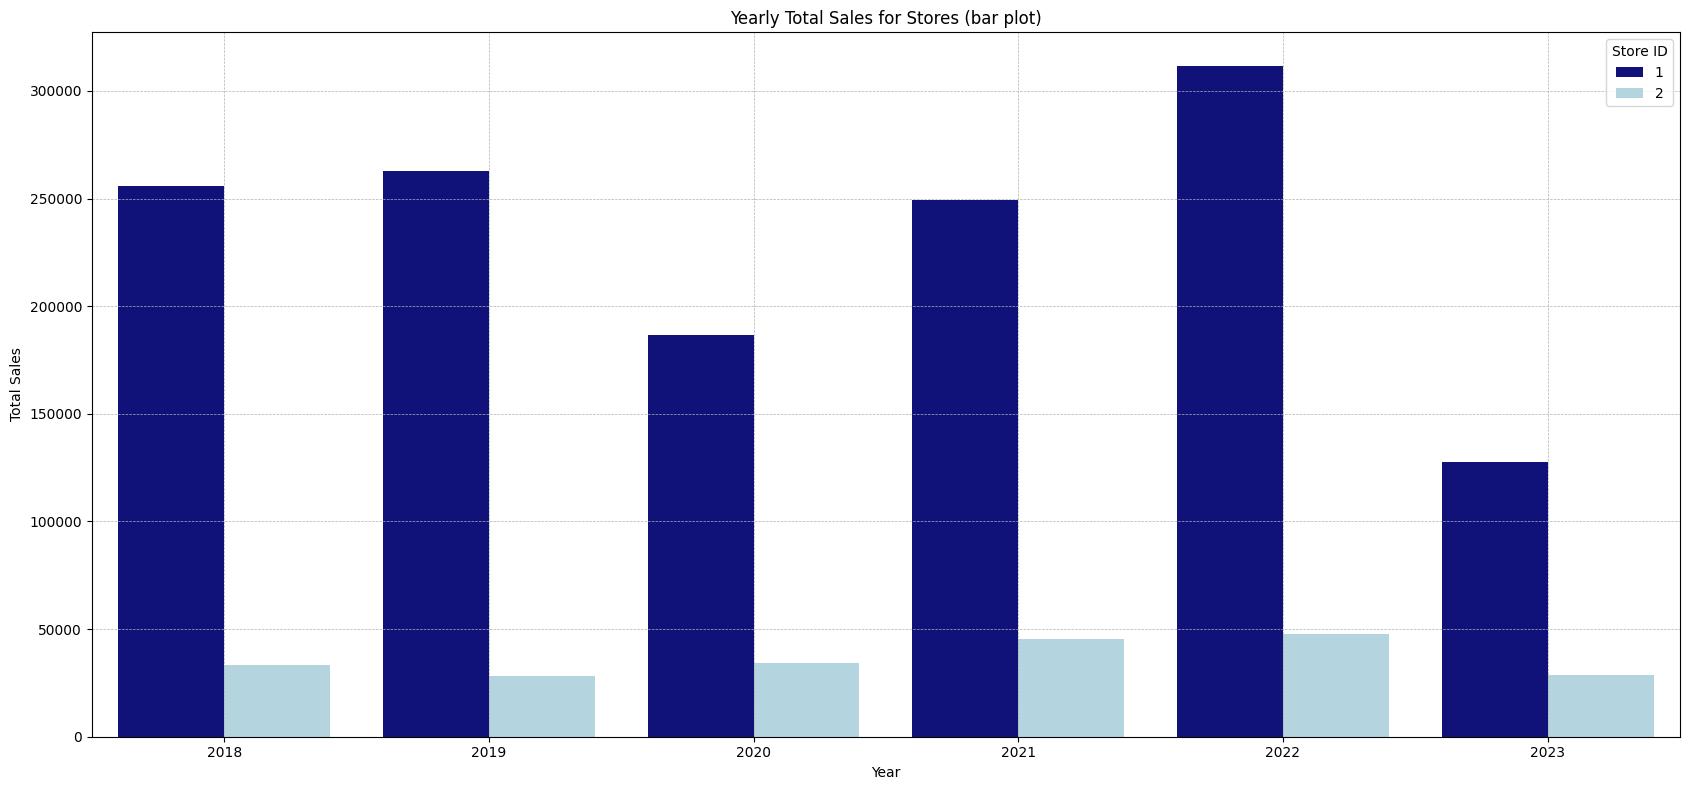

In [258]:
# Total Sales
plot_sales(sales, store_colors, frequency='yearly')

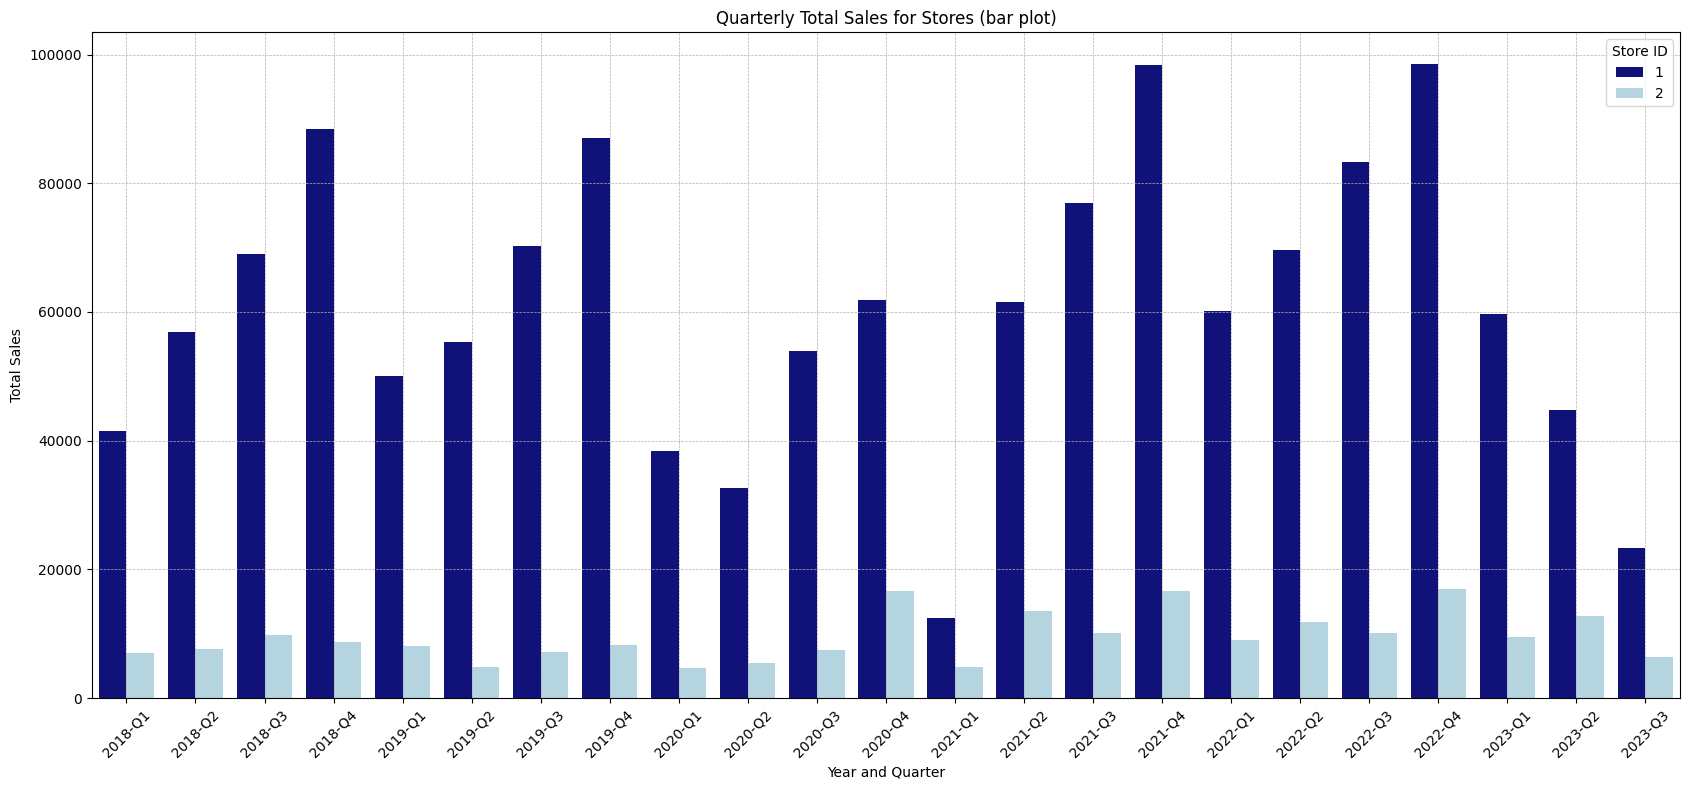

In [259]:
plot_sales(sales, store_colors, frequency='quarterly')

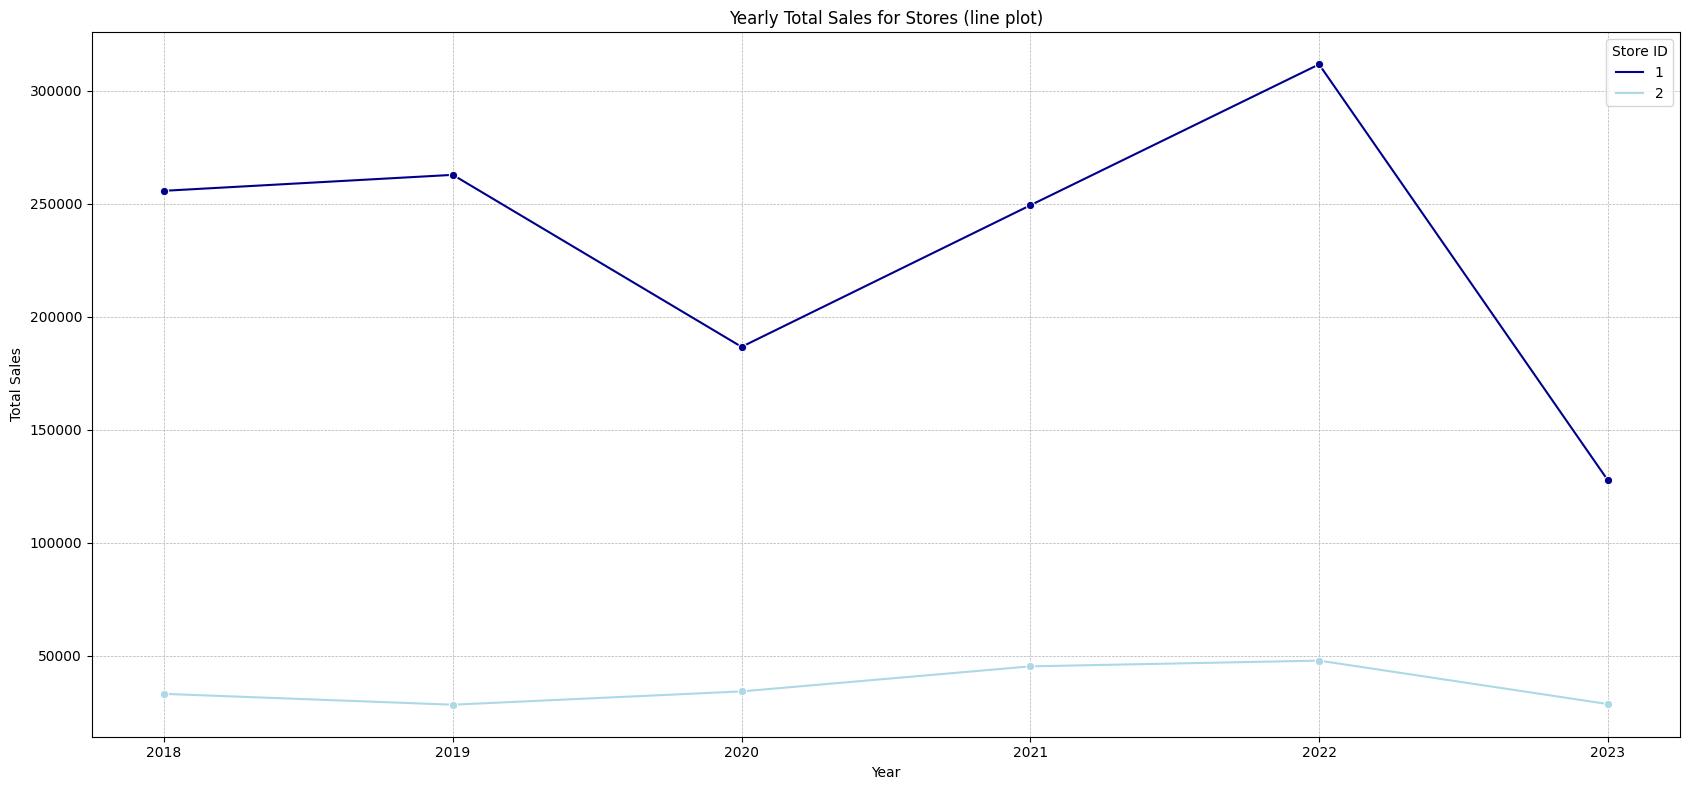

In [260]:
plot_sales(sales, store_colors, frequency='yearly', plot_type='line')


### Products & Materials

In [261]:
sales['PRODUCT'].value_counts()

PRODUCT
BATTERY             8130
REPAIR ITEM         5964
EARRING             4594
NECKLACE            3924
BRACELET            3392
CHARM               2827
BRACELET WATCH      2396
RING                1849
WATCHES             1460
EAR PIERCING        1429
HOOPS               1247
COMMITMENT RINGS    1047
WEDDING RING         672
MEDAL                666
WATCH ITEM           454
DECORATION           410
FRAME                326
RELIGIOUS ITEM       311
NOSE PIRCING         287
SMART WATCHES        281
KIDS DECORATION      275
ENGRAVING            175
PEN                  118
ALARM CLOCK          117
RELIGIOUS CHARM      117
KIDS EARRINGS        112
EARRING ITEM          85
SHIPPING              71
ACESSORIES            67
BAG                   65
NECKLACE ITEM         65
KIDS BRACELET         53
DIAMOND               35
KIDS ACESSORIES       34
LAPEL PIN             32
PEN ACESSORIES        28
KIDS WATCHES          24
CUFFLINKS             23
SERVICES              20
KIDS RING        

In [262]:
sales['MATERIAL'].value_counts()

MATERIAL
SILVER 925             15626
BATTERY                 8130
STEEL                   5785
NOT DEFINED             5668
GOLD 800                2324
LEATHER                 1786
GOLD 375                 995
BILAMINATE               962
SILVER GOLD 925          956
GOLD 750                 173
SILVER 835               164
GOLD 375 SILVER 925      164
NOT APPLICABLE           149
RUBBER                   148
PLASTIC                   86
STEEL GOLD 750            52
DIAMOND                   46
GOLD 585                  34
PEARL                     18
SILVER 800                17
GLASS                     15
GOLD 800 SILVER 925        9
STONE                      6
SILVER                     5
GOLD 800 DIAMOND           4
GOLD 900                   3
GOLD 916                   2
GOLD 300                   2
SILVER GOLD 835            2
SILVER                     1
SILVER GOLD 830            1
NOT DEFINED                1
GOOLD GEM                  1
Name: count, dtype: int64

#### The 10 Best-Selling and Least-Selling Products by Sales

In [263]:
def plot_products_by_sales(data, store_colors, top=True, N=10):
    
    plt.figure(figsize=(20, 10))

    # Loop through the unique store IDs to create subplots for each store
    for i, store in enumerate(data['Store_ID'].unique(), 1):
        
        # Filter the data for the current store
        store_sales = data[data['Store_ID'] == store]
        
        # Group by PRODUCT and sum the TOTAL_SALES
        product_sales_totals = store_sales.groupby('PRODUCT')['TOTAL_SALES'].sum()
        
        # Get Top/Bottom N products by sales for the current store
        if top:
            product_sales_store = product_sales_totals.nlargest(N)
        else:
            product_sales_store = product_sales_totals.nsmallest(N)
        
        # Create the subplot
        plt.subplot(1, 2, i)
        sns.barplot(y=product_sales_store.index, x=product_sales_store.values, palette="viridis", color=store_colors[store])
        plt.title(f'{"Top" if top else "Least"} {N} Products by Sales for Store {store}')
        plt.xlabel('Total Sales')
        plt.ylabel('Product')

    plt.tight_layout()
    plt.show()

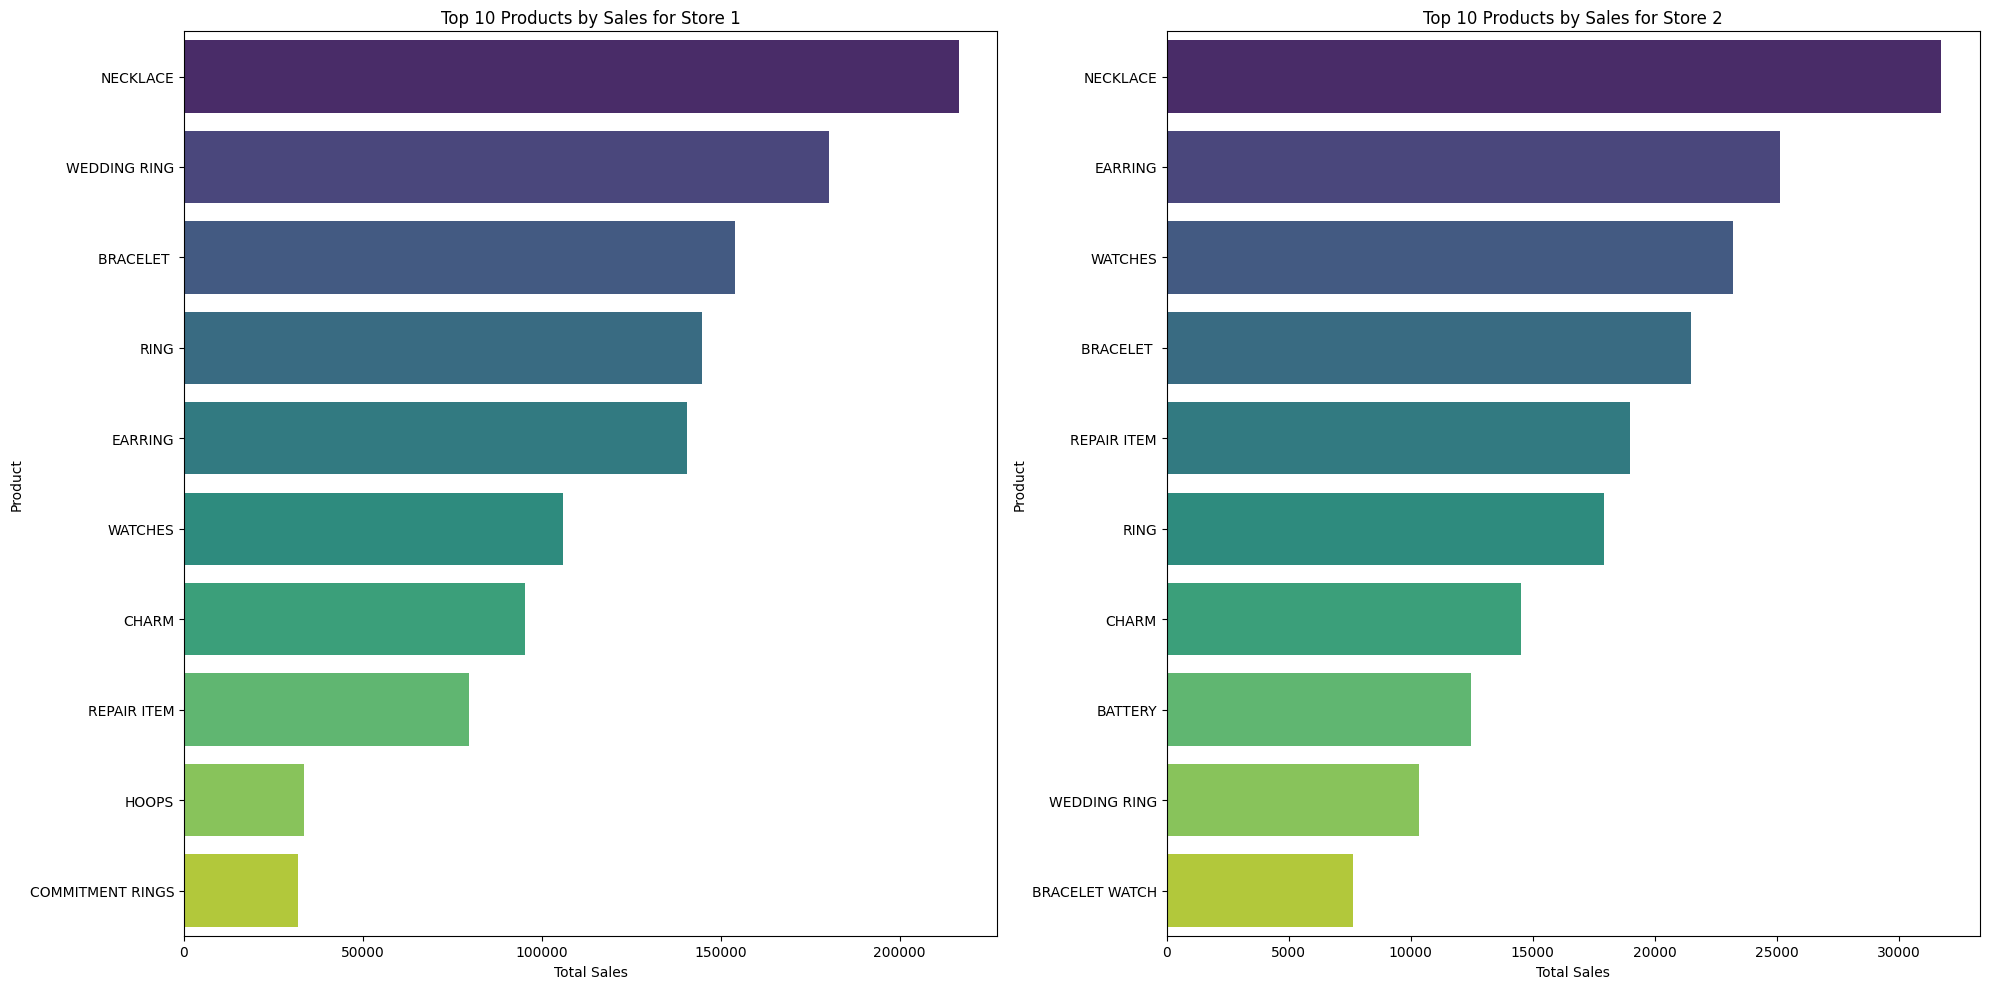

In [264]:
plot_products_by_sales(sales, store_colors, top=True, N=10)

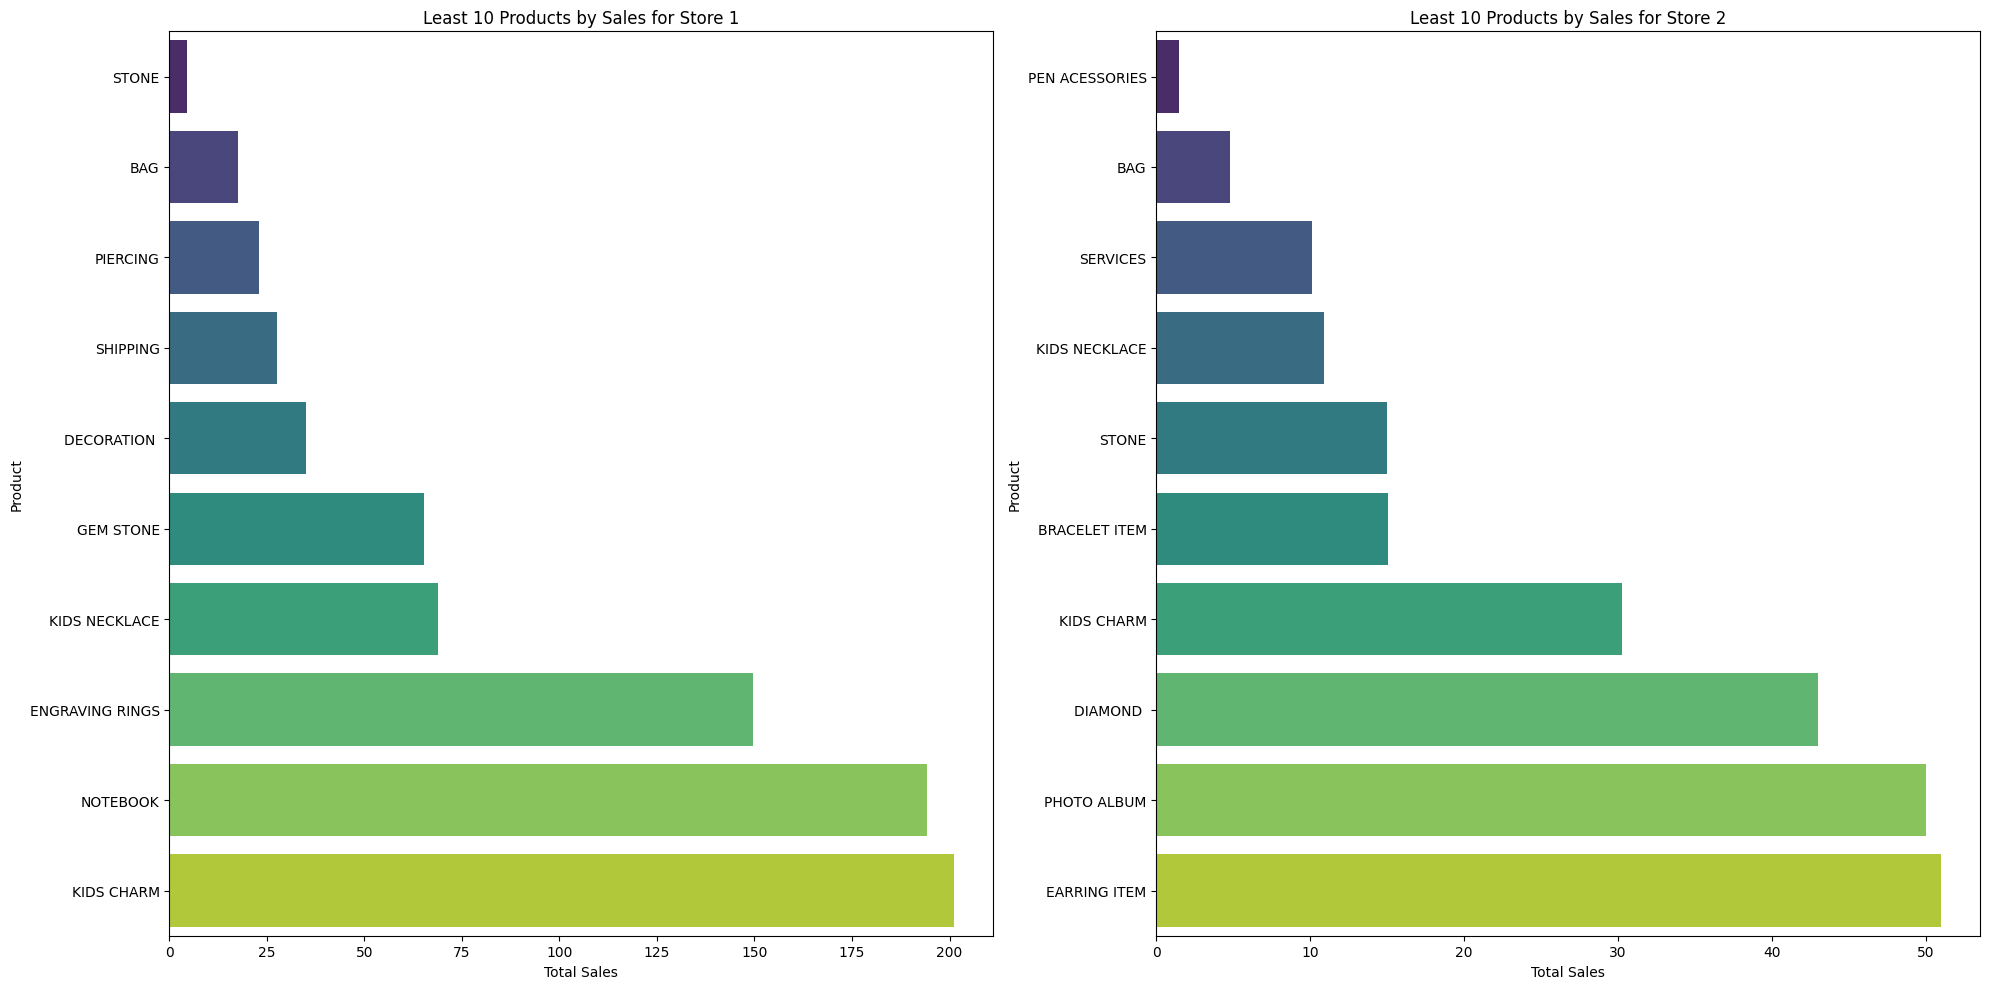

In [265]:
plot_products_by_sales(sales, store_colors, top=False, N=10)

#### The 10 Best-Selling and Least-Selling Products by Quantity

In [266]:
def plot_products_by_quantity(data, store_colors, top=True, N=10):
    plt.figure(figsize=(20, 10))

    # Loop through the unique store IDs to create subplots for each store
    for i, store in enumerate(data['Store_ID'].unique(), 1):
        
        # Filter the data for the current store
        store_sales = data[data['Store_ID'] == store]
        
        # Count the occurrences of each product
        product_counts = store_sales['PRODUCT'].value_counts()
        
        # Get Top/Bottom N products by quantity for the current store
        if top:
            product_sales_store = product_counts.nlargest(N)
        else:
            product_sales_store = product_counts.nsmallest(N)
        
        # Create the subplot
        plt.subplot(1, 2, i)
        sns.barplot(y=product_sales_store.index, x=product_sales_store.values, palette="viridis", color=store_colors[store])
        plt.title(f'{"Top" if top else "Least"} {N} Sold Products by Quantity for Store {store}')
        plt.xlabel('Quantity Sold')
        plt.ylabel('Product')

    plt.tight_layout()
    plt.show()



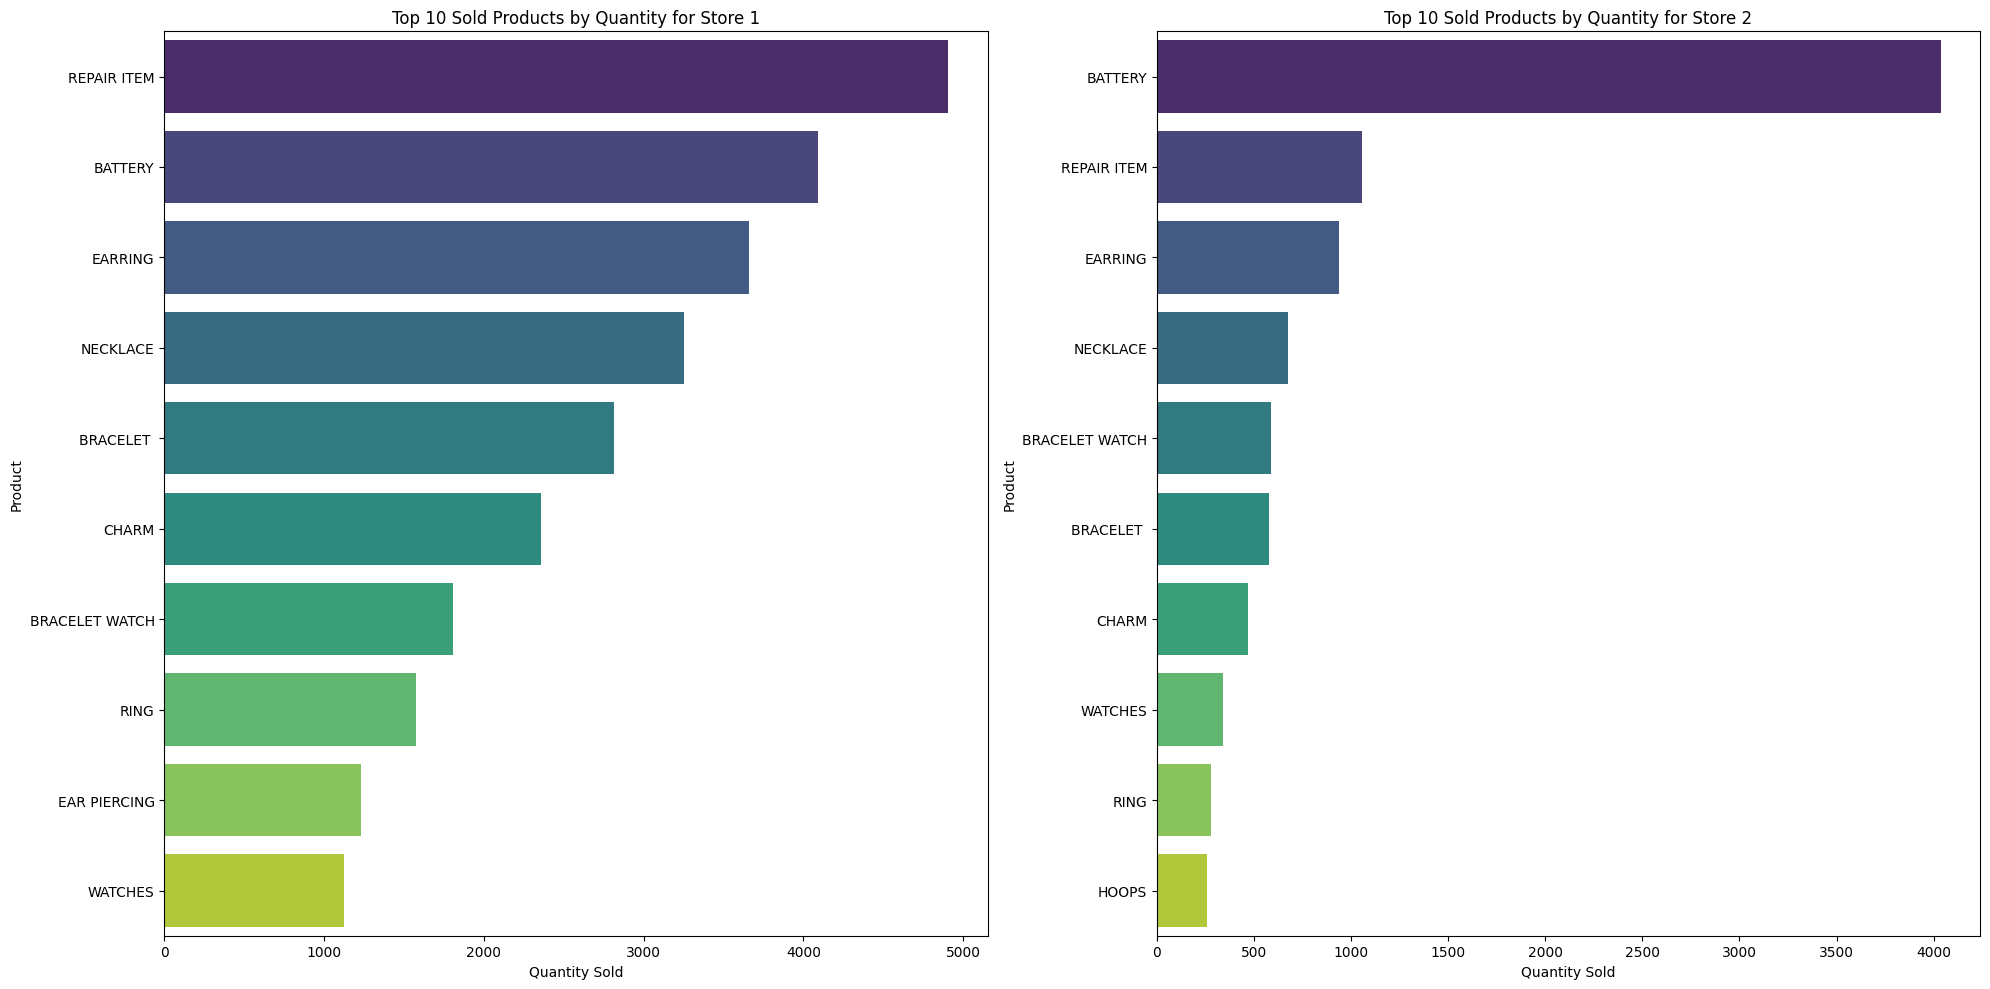

In [267]:
plot_products_by_quantity(sales, store_colors, top=True, N=10)

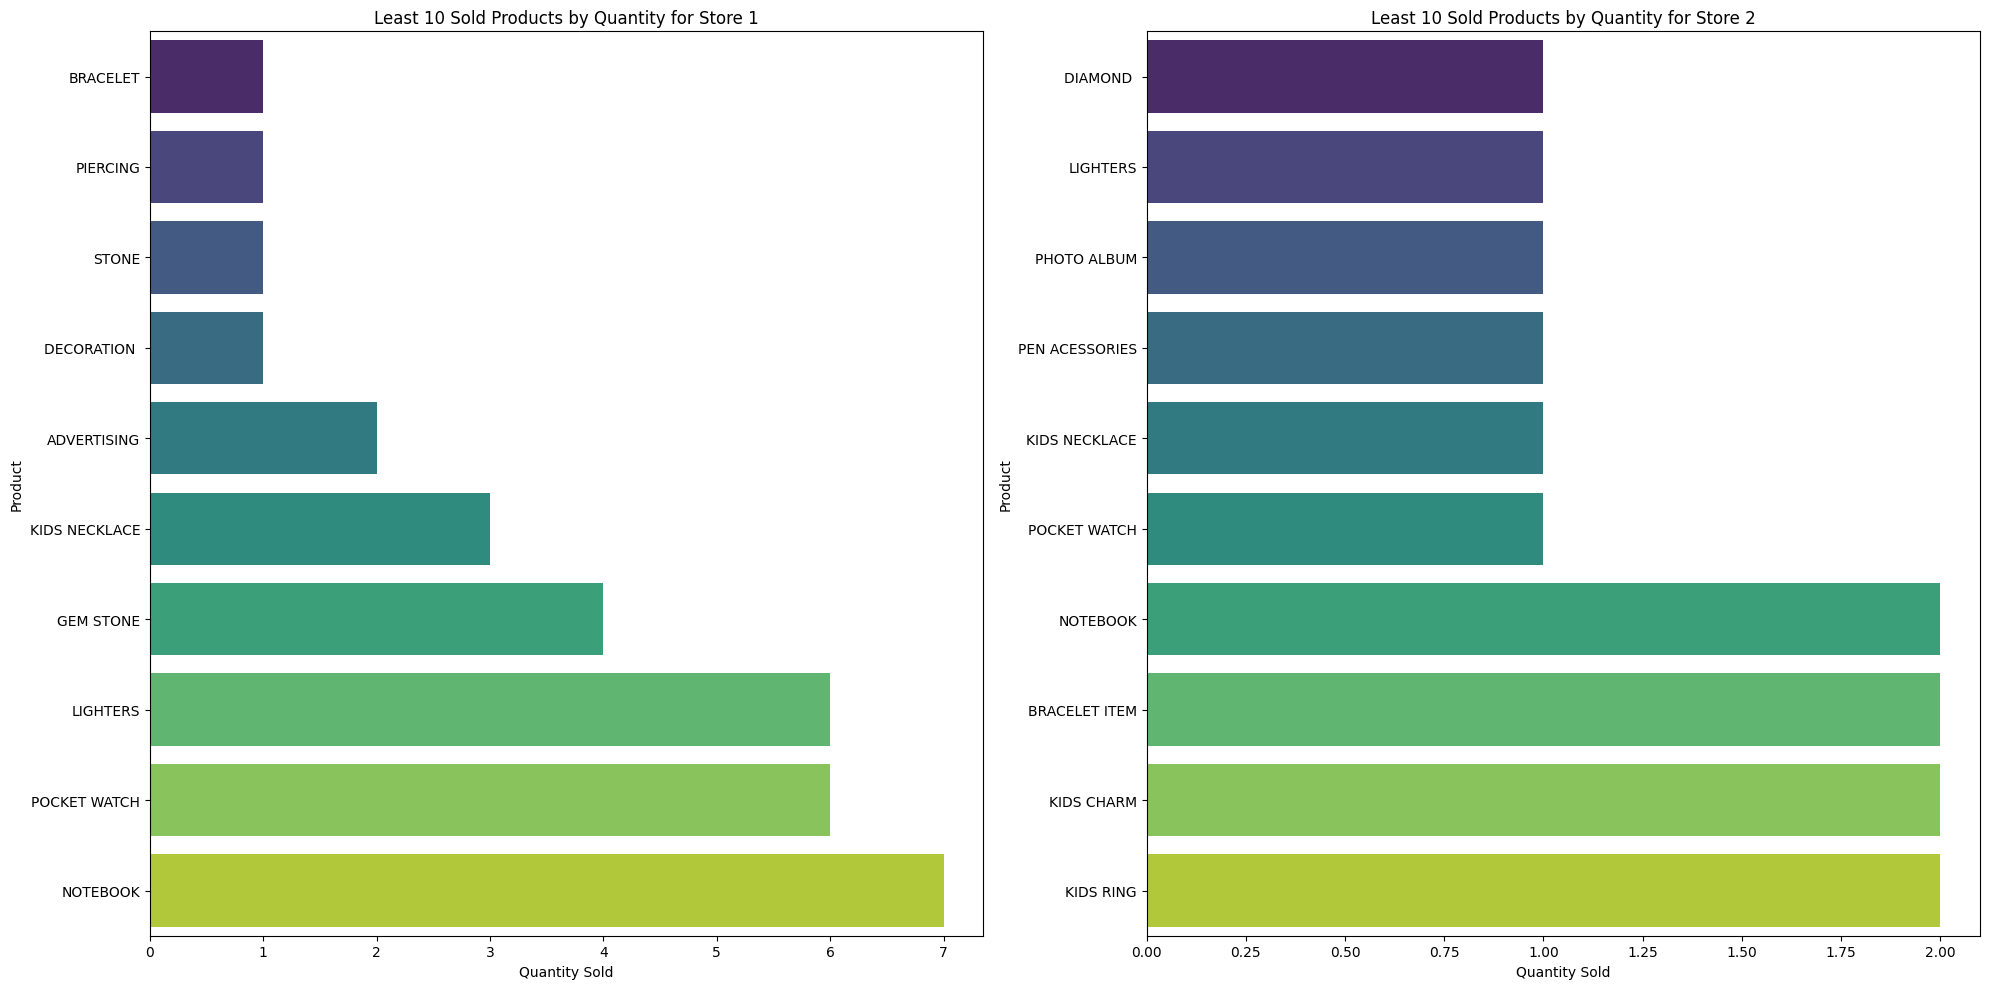

In [268]:
plot_products_by_quantity(sales, store_colors, top=False, N=10)

#### The 10 Best-Selling and Least-Selling Materials by Sales

In [269]:
def plot_materials_by_sales(data, store_colors, top=True, N=10):
      
    plt.figure(figsize=(20, 10))

    # Loop through the unique store IDs to create subplots for each store
    for i, store in enumerate(data['Store_ID'].unique(), 1):
        
        # Filter the data for the current store
        store_sales = data[data['Store_ID'] == store]
        
        # Group by MATERIAL and sum the TOTAL_SALES
        material_sales_totals = store_sales.groupby('MATERIAL')['TOTAL_SALES'].sum()
        
        # Get Top/Bottom N materials by sales for the current store
        if top:
            material_sales_store = material_sales_totals.nlargest(N)
        else:
            material_sales_store = material_sales_totals.nsmallest(N)
        
        # Create the subplot
        plt.subplot(1, 2, i)
        sns.barplot(y=material_sales_store.index, x=material_sales_store.values, palette="viridis", color=store_colors[store])
        plt.title(f'{"Top" if top else "Least"} {N} Materials by Sales for Store {store}')
        plt.xlabel('Total Sales')
        plt.ylabel('Material')

    plt.tight_layout()
    plt.show()




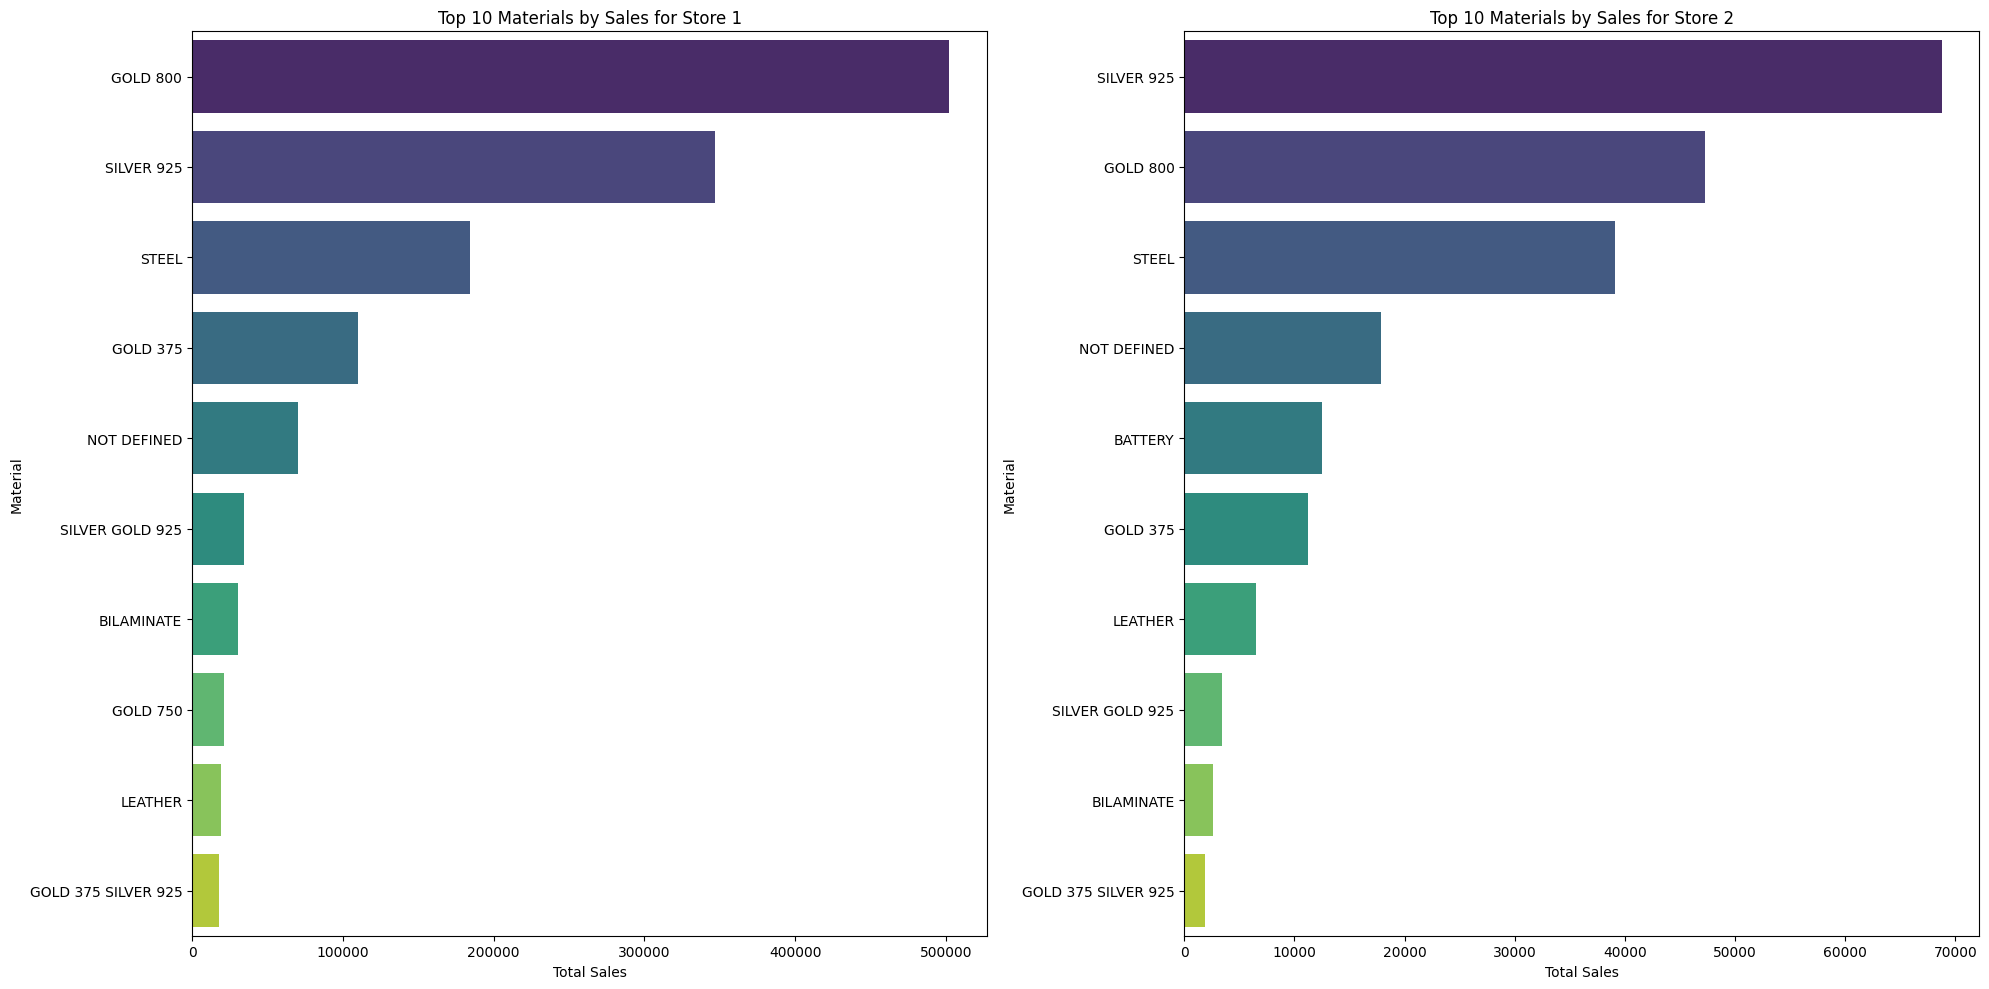

In [270]:
plot_materials_by_sales(sales, store_colors, top=True, N=10)


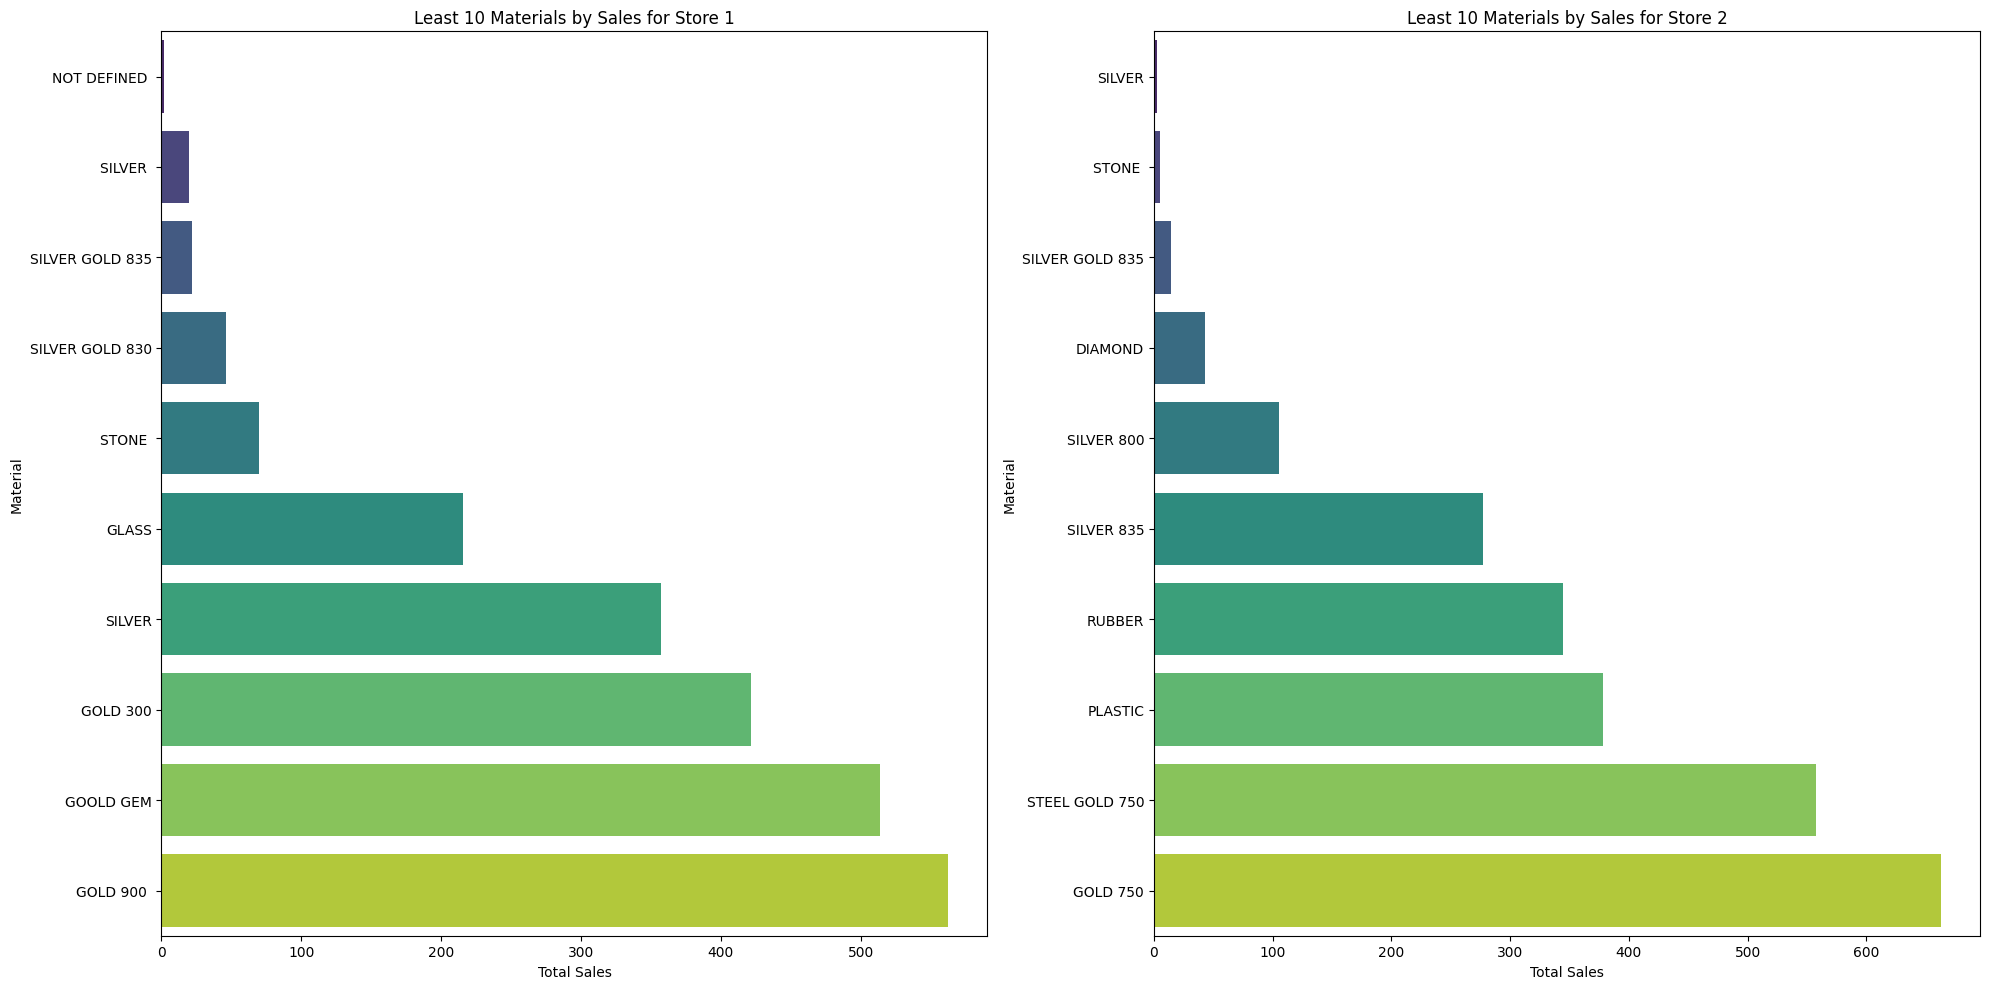

In [271]:
plot_materials_by_sales(sales, store_colors, top=False, N=10)

#### The 10 Best-Selling and Least-Selling Materials by Quantity

In [272]:
def plot_materials_by_quantity(data, store_colors, top=True, N=10):
   
    plt.figure(figsize=(20, 10))

    # Loop through the unique store IDs to create subplots for each store
    for i, store in enumerate(data['Store_ID'].unique(), 1):
        
        # Filter the data for the current store
        store_sales = data[data['Store_ID'] == store]
        
        # Count the occurrences of each material
        material_counts = store_sales['MATERIAL'].value_counts()
        
        # Get Top/Bottom N materials by quantity for the current store
        if top:
            material_sales_store = material_counts.nlargest(N)
        else:
            material_sales_store = material_counts.nsmallest(N)
        
        # Create the subplot
        plt.subplot(1, 2, i)
        sns.barplot(y=material_sales_store.index, x=material_sales_store.values, palette="viridis", color=store_colors[store])
        plt.title(f'{"Top" if top else "Least"} {N} Sold Materials by Quantity for Store {store}')
        plt.xlabel('Quantity Sold')
        plt.ylabel('Material')

    plt.tight_layout()
    plt.show()

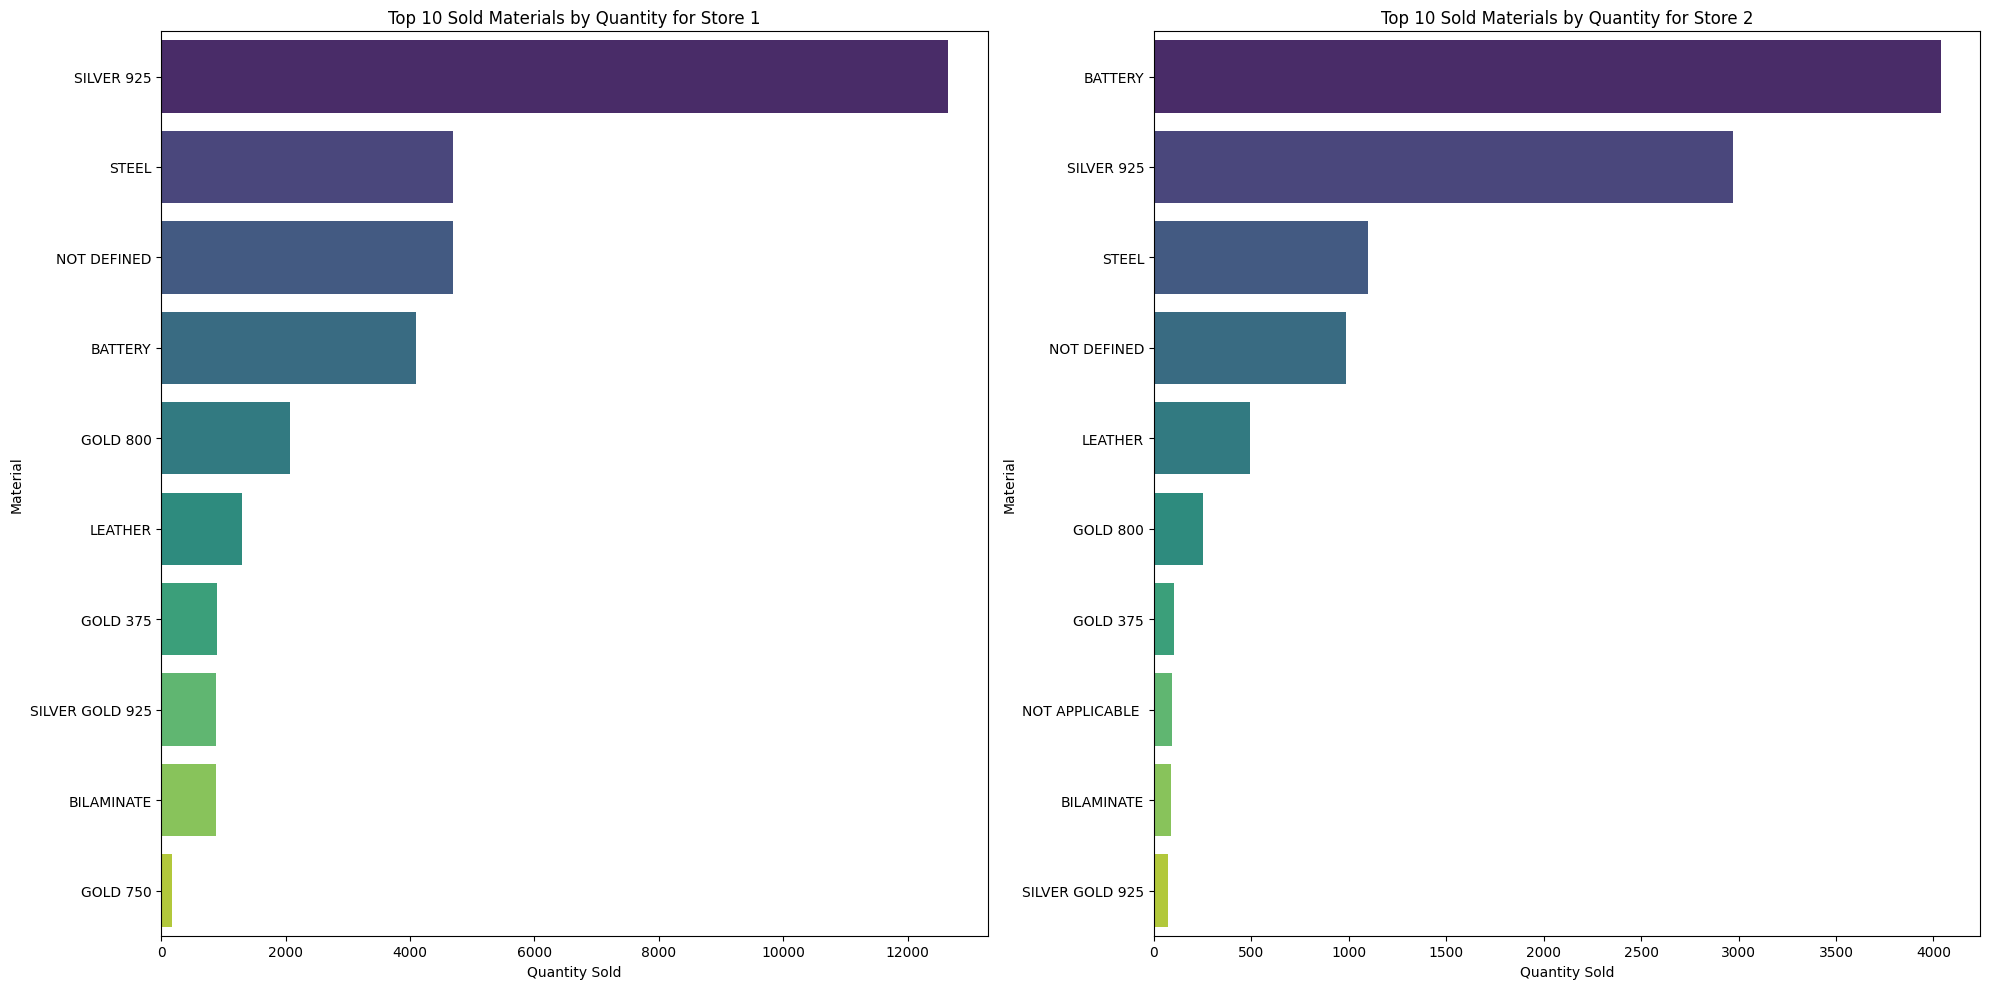

In [273]:
plot_materials_by_quantity(sales, store_colors, top=True, N=10)

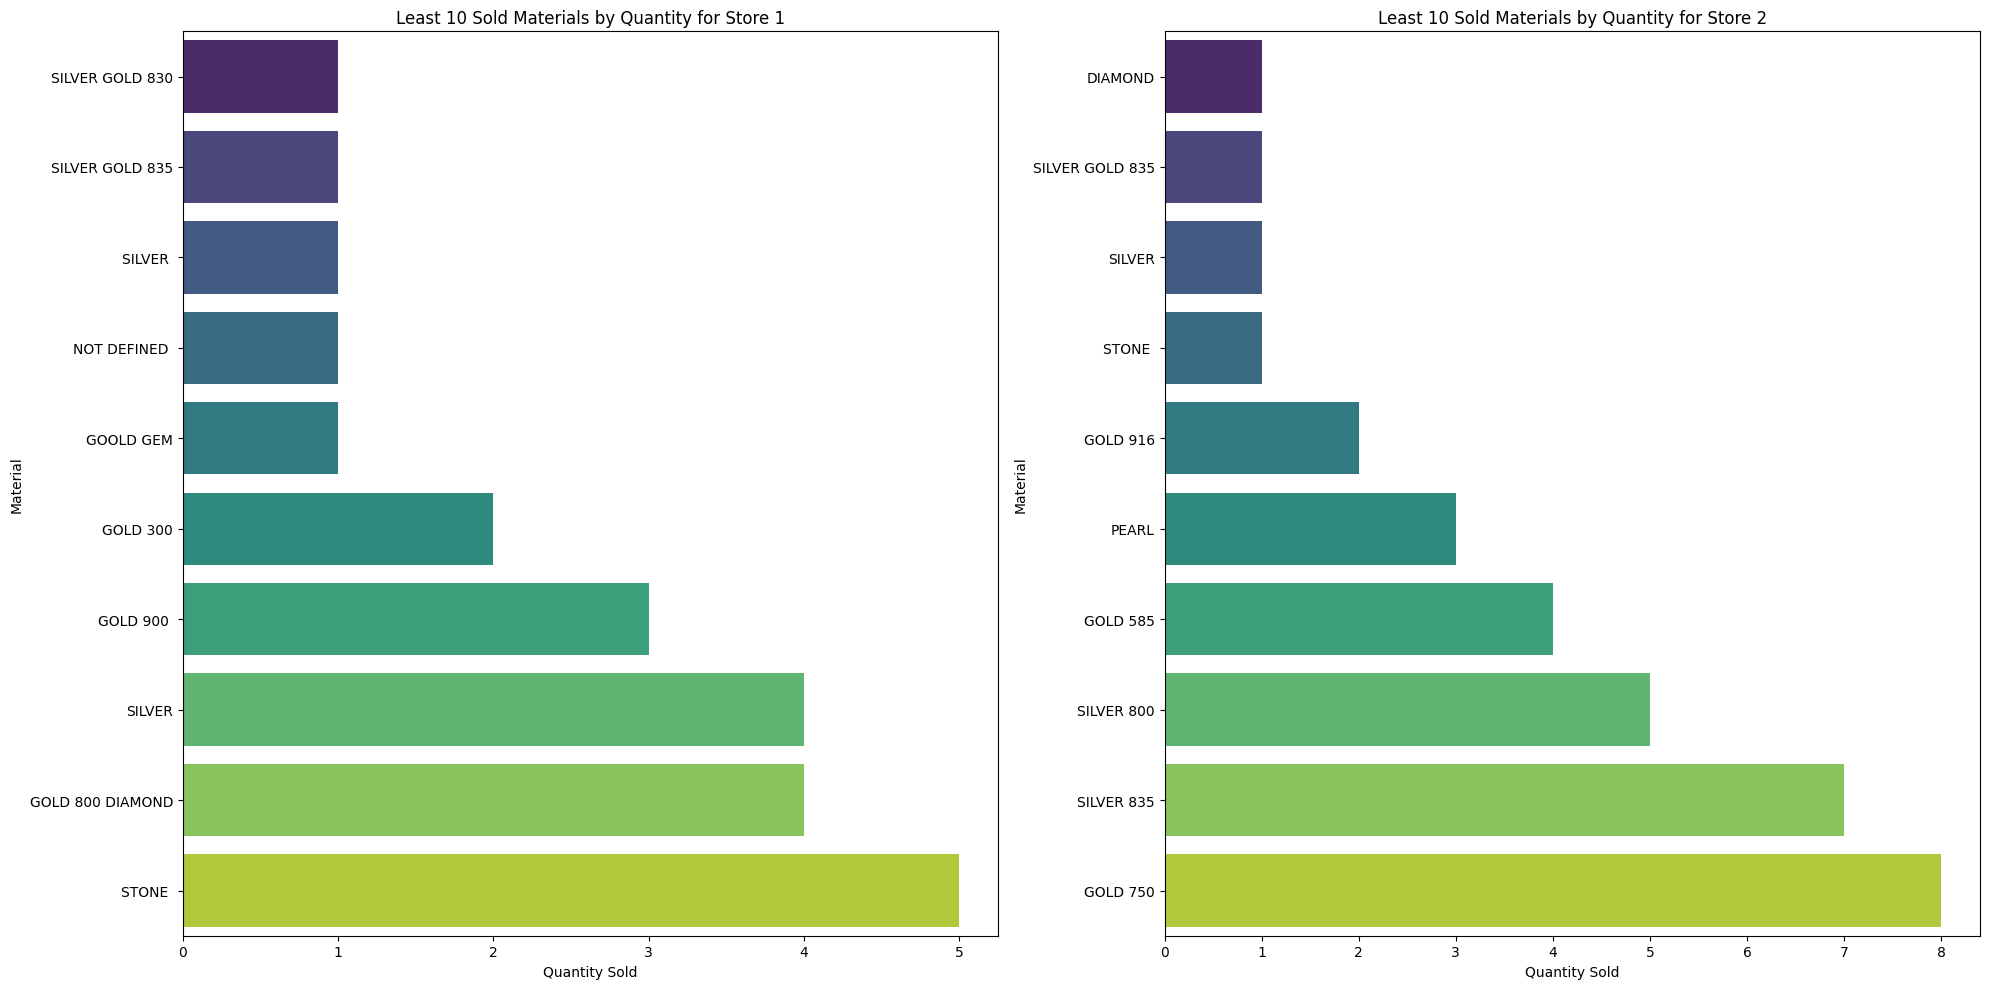

In [274]:
plot_materials_by_quantity(sales, store_colors, top=False, N=10)

##### Evolution of Sales of Products 

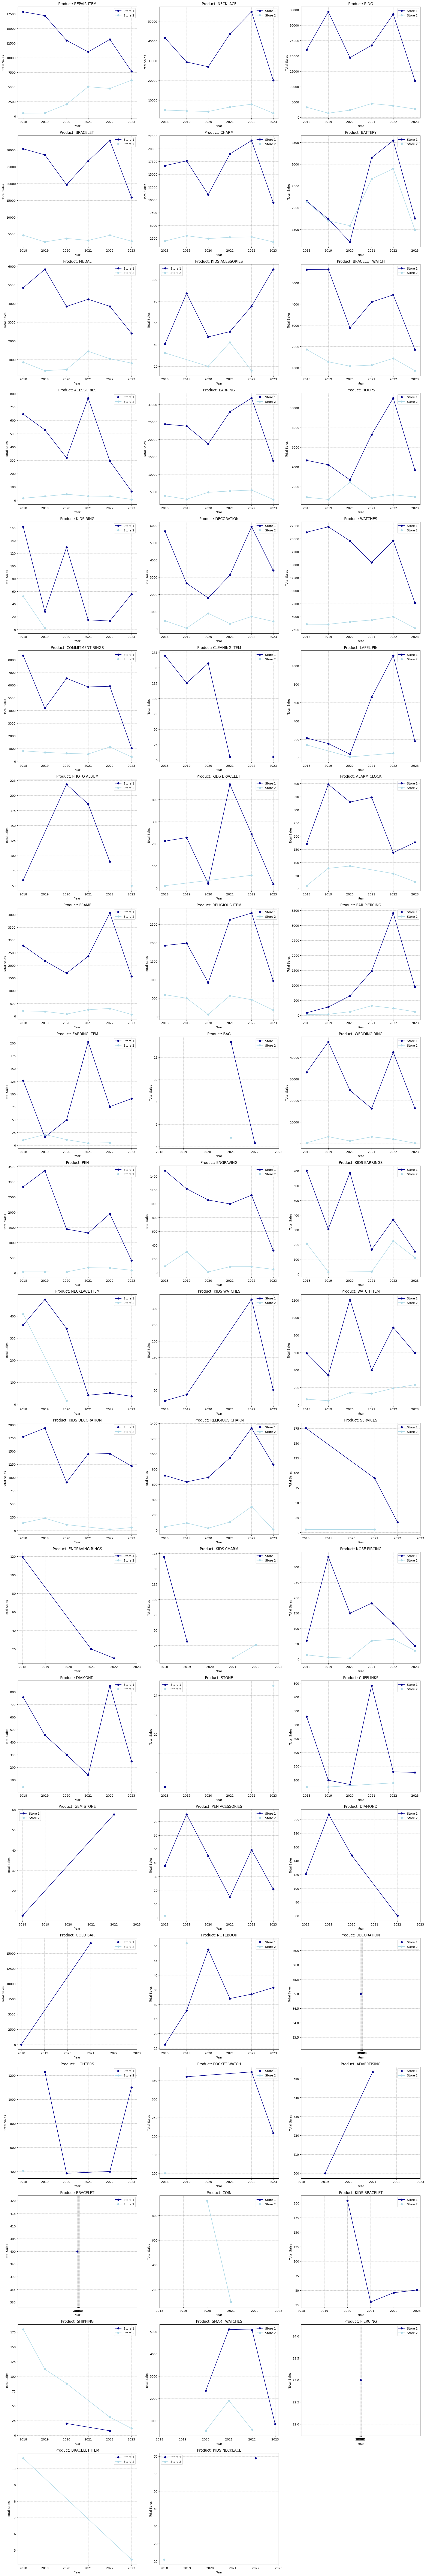

In [275]:
product_sales_evolution = sales.groupby(['PRODUCT', 'Store_ID', 'YEAR'])['TOTAL_SALES'].sum().reset_index()
unique_products = sales['PRODUCT'].unique()
number_of_rows = len(unique_products) // 3 + len(unique_products) % 3
graphs_per_row = 3

# Plotting the data for each product with the given colors
fig, axes = plt.subplots(nrows=number_of_rows, ncols=graphs_per_row, figsize=(20, 6 * number_of_rows))

# Adjusting the shape of the 'axes' variable for easier manipulation
if number_of_rows == 1 or graphs_per_row == 1:
    axes = axes.reshape(1, -1)

# Plotting the data for each product
for idx, product in enumerate(unique_products):
    row = idx // graphs_per_row
    col = idx % graphs_per_row
    
    product_data_store1 = product_sales_evolution[(product_sales_evolution['PRODUCT'] == product) & (product_sales_evolution['Store_ID'] == 1)]
    product_data_store2 = product_sales_evolution[(product_sales_evolution['PRODUCT'] == product) & (product_sales_evolution['Store_ID'] == 2)]
    
    axes[row, col].plot(product_data_store1['YEAR'], product_data_store1['TOTAL_SALES'], color='darkblue', label='Store 1', marker='o')
    axes[row, col].plot(product_data_store2['YEAR'], product_data_store2['TOTAL_SALES'], color='lightblue', label='Store 2', marker='o')
    
    axes[row, col].set_title(f'Product: {product}')
    axes[row, col].set_xlabel('Year')
    axes[row, col].set_ylabel('Total Sales')
    axes[row, col].legend()
    axes[row, col].grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Only whole years are displayed on the Y-axis
    axes[row, col].set_xticks(product_sales_evolution['YEAR'].unique())

# Remove empty plots (if any)
for idx in range(len(unique_products), number_of_rows * graphs_per_row):
    row = idx // graphs_per_row
    col = idx % graphs_per_row
    fig.delaxes(axes[row][col])

plt.tight_layout()
plt.show()


#### Monthly/semi-annual/annual sales trend to identify seasonal patterns

In [276]:
def get_sales_trend(data):
    # Monthly Trend
    monthly = data.groupby(['YEAR', 'MONTH']).agg({'TOTAL_SALES': 'sum'}).reset_index()
    monthly['DATE'] = pd.to_datetime(monthly[['YEAR', 'MONTH']].assign(DAY=1))
    monthly.set_index('DATE', inplace=True)
    
    # Semi-annual Trend
    semestral = data.copy()
    semestral['SEMESTER'] = np.where(semestral['MONTH'] <= 6, 1, 2)
    semestral = semestral.groupby(['YEAR', 'SEMESTER']).agg({'TOTAL_SALES': 'sum'}).reset_index()
    semestral['DATE'] = pd.to_datetime(semestral['YEAR'].astype(str) + '-' + (semestral['SEMESTER']*6).astype(str) + '-01')
    semestral.set_index('DATE', inplace=True)
    
    # Annual Trend
    annual = data.groupby(['YEAR']).agg({'TOTAL_SALES': 'sum'})
    
    return monthly, semestral, annual

store_1_data = sales[sales['Store_ID'] == 1]
store_2_data = sales[sales['Store_ID'] == 2]

store_1_monthly, store_1_semestral, store_1_annual = get_sales_trend(store_1_data)
store_2_monthly, store_2_semestral, store_2_annual = get_sales_trend(store_2_data)

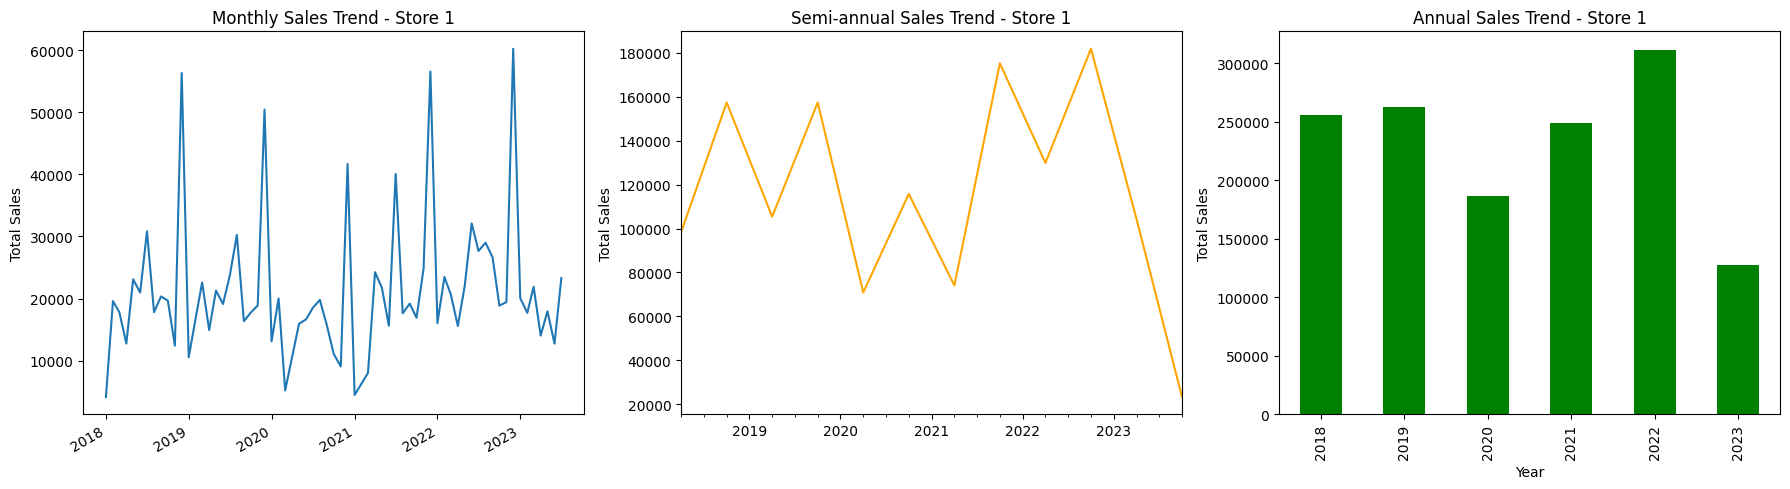

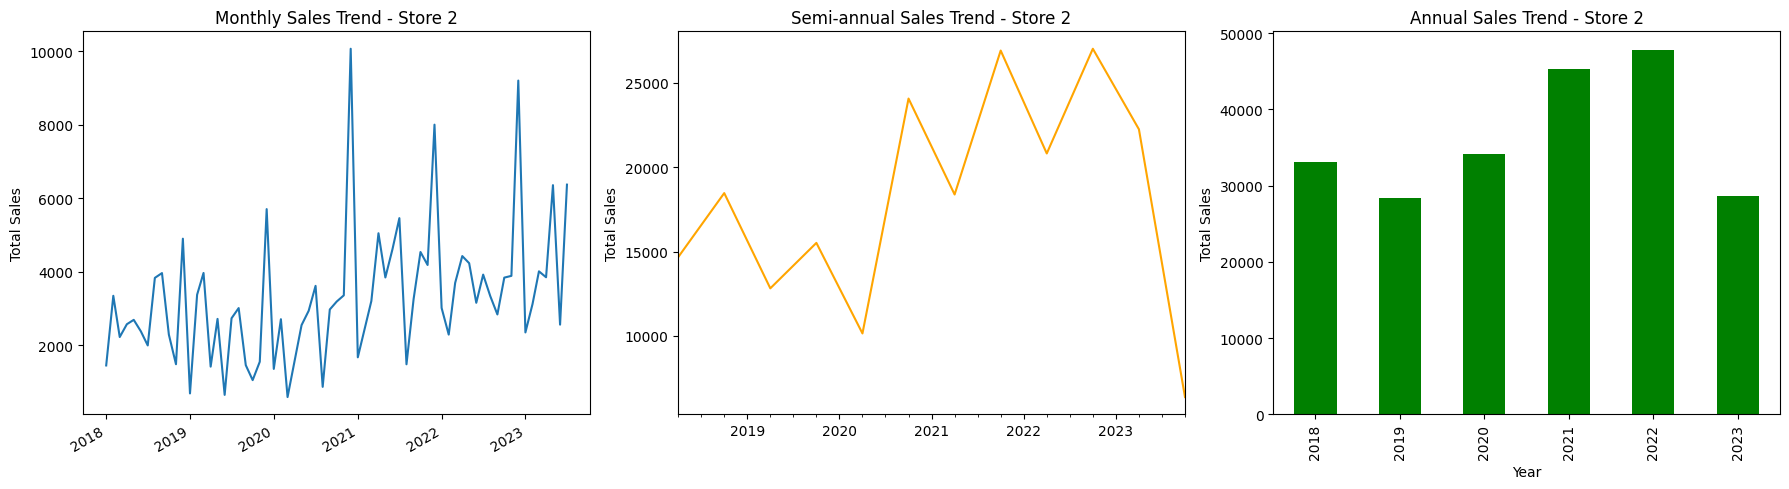

In [277]:
# Plotting the trends for Store 1
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
store_1_monthly['TOTAL_SALES'].plot(title='Monthly Sales Trend - Store 1')
plt.xlabel('')
plt.ylabel('Total Sales')

plt.subplot(1, 3, 2)
store_1_semestral['TOTAL_SALES'].plot(title='Semi-annual Sales Trend - Store 1', color='orange')
plt.xlabel('')
plt.ylabel('Total Sales')

plt.subplot(1, 3, 3)
store_1_annual['TOTAL_SALES'].plot(title='Annual Sales Trend - Store 1', kind='bar', color='green')
plt.xlabel('Year')
plt.ylabel('Total Sales')

plt.tight_layout()
plt.show()

# Plotting the trends for Store 2
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
store_2_monthly['TOTAL_SALES'].plot(title='Monthly Sales Trend - Store 2')
plt.xlabel('')
plt.ylabel('Total Sales')

plt.subplot(1, 3, 2)
store_2_semestral['TOTAL_SALES'].plot(title='Semi-annual Sales Trend - Store 2', color='orange')
plt.xlabel('')
plt.ylabel('Total Sales')

plt.subplot(1, 3, 3)
store_2_annual['TOTAL_SALES'].plot(title='Annual Sales Trend - Store 2', kind='bar', color='green')
plt.xlabel('Year')
plt.ylabel('Total Sales')

plt.tight_layout()
plt.show()

*Interpretation of the results*

- Store 1 consistently achieves higher sales than Store 2 across all periods. While both stores exhibit similar sales patterns, the magnitude of sales is higher for Store 1. This could be attributed to various factors, such as location, store size, marketing efforts, or customer base.
- Store 2, however, shows promise in its growth rate, especially in the recent years, suggesting it might be building its customer base or implementing effective sales strategies.

## Sales & Profit

### For Each Store

In [278]:
sales_profit_analysis = sales.groupby('Store_ID').agg({'TOTAL_SALES': 'sum', 'PROFIT': 'sum'}).reset_index()
sales_profit_analysis[['TOTAL_SALES', 'PROFIT']] = sales_profit_analysis[['TOTAL_SALES', 'PROFIT']].round(2)
sales_profit_analysis

Store_ID  TOTAL_SALES     PROFIT
0         1   1393817.64  489049.31
1         2    217415.69   76278.96

#### Per Year

In [279]:
sales_profit_analysis_yearly = sales.groupby(['Store_ID', 'YEAR']).agg({'TOTAL_SALES': 'sum', 'PROFIT': 'sum'}).reset_index()
sales_profit_analysis_yearly[['TOTAL_SALES', 'PROFIT']] = sales_profit_analysis_yearly[['TOTAL_SALES', 'PROFIT']].round(2)

# Splitting the data by store
store1_data = sales_profit_analysis_yearly[sales_profit_analysis_yearly['Store_ID'] == 1].set_index('YEAR').drop(columns=['Store_ID'])
store2_data = sales_profit_analysis_yearly[sales_profit_analysis_yearly['Store_ID'] == 2].set_index('YEAR').drop(columns=['Store_ID'])

print("Sales & Profit Store 1")
display(store1_data)

Sales & Profit Store 1


TOTAL_SALES     PROFIT
YEAR                        
2018    255721.39   84076.63
2019    262776.40   87649.20
2020    186671.80   64704.48
2021    249313.09   87784.99
2022    311672.32  117105.32
2023    127662.66   47728.69

In [280]:
print("Sales & Profit Store 2")
display(store2_data)

Sales & Profit Store 2


TOTAL_SALES    PROFIT
YEAR                       
2018     33126.33  11311.26
2019     28327.76   9039.06
2020     34211.45  11669.86
2021     45296.58  16077.67
2022     47836.90  17695.08
2023     28616.67  10486.04

#### Plot Profit and Sales over the years

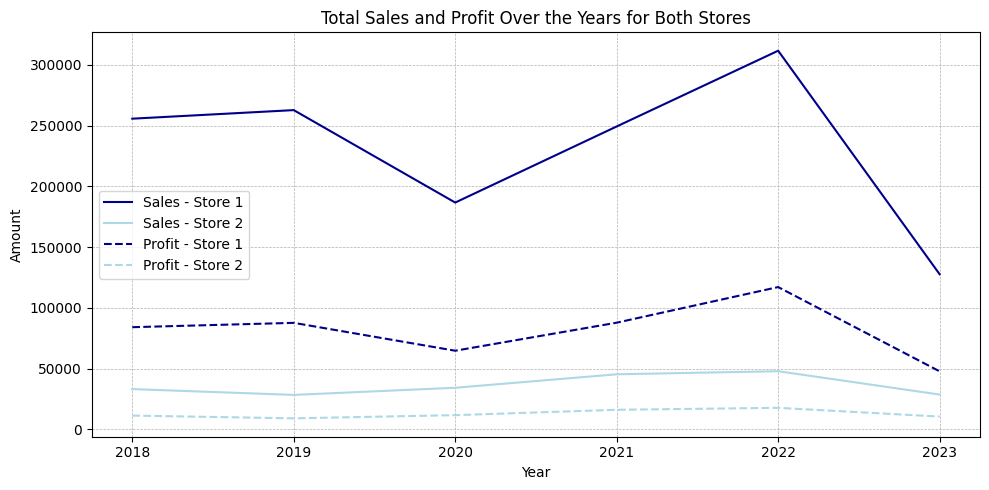

In [281]:
plt.figure(figsize=(10, 5))
colors = {
    1: 'darkblue',
    2: 'lightblue'
}
# Plotting Sales
for store_id in [1, 2]:
    subset = sales_profit_analysis_yearly[sales_profit_analysis_yearly['Store_ID'] == store_id]
    plt.plot(subset['YEAR'], subset['TOTAL_SALES'], label=f'Sales - Store {store_id}', color=colors[store_id], linestyle='-')
    
# Plotting Profit
for store_id in [1, 2]:
    subset = sales_profit_analysis_yearly[sales_profit_analysis_yearly['Store_ID'] == store_id]
    plt.plot(subset['YEAR'], subset['PROFIT'], label=f'Profit - Store {store_id}', color=colors[store_id], linestyle='--')

plt.title('Total Sales and Profit Over the Years for Both Stores')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


*Interpretation of the results*
- Store 1: Sales seem to have an upward trend, with some fluctuations over the years. Given its longevity, it's possible that the store has established a loyal customer base over the years, contributing to sustained growth.

- Store 2: The sales trend also shows growth, but the sales volume is visibly smaller than that of Store 1. However, it's important to note that Store 2 has been operational since 2011, so it has fewer years of data compared to Store 1.

The chart highlights the performance difference between the two stores and suggests that longevity might play a role in customer loyalty and brand recognition, especially for Store 1. 

### Most Profit Product Per Year

In [282]:
# Grouping and sorting to get the most profitable product for each store per year
max_profit_product = (sales.groupby(['Store_ID', 'YEAR', 'PRODUCT'])
                      .agg({'PROFIT': 'sum'})
                      .reset_index()
                      .sort_values(by=['Store_ID', 'YEAR', 'PROFIT'], ascending=[True, True, False])
                      .drop_duplicates(subset=['Store_ID', 'YEAR']))

max_profit_product_store1 = max_profit_product[max_profit_product['Store_ID'] == 1]
max_profit_product_store2 = max_profit_product[max_profit_product['Store_ID'] == 2]


In [283]:
display(max_profit_product_store1)

Store_ID  YEAR       PRODUCT        PROFIT
30          1  2018      NECKLACE  14281.443893
90          1  2019  WEDDING RING  14868.046557
118         1  2020      NECKLACE   9491.745871
163         1  2021      NECKLACE  16693.263563
211         1  2022      NECKLACE  22182.380197
256         1  2023      NECKLACE   7363.159290

In [284]:
display(max_profit_product_store2)

Store_ID  YEAR      PRODUCT       PROFIT
297         2  2018     NECKLACE  1680.961646
331         2  2019     NECKLACE  1416.049140
353         2  2020      EARRING  1710.299666
394         2  2021     NECKLACE  2490.673889
428         2  2022     NECKLACE  2785.282978
463         2  2023  REPAIR ITEM  1984.800490

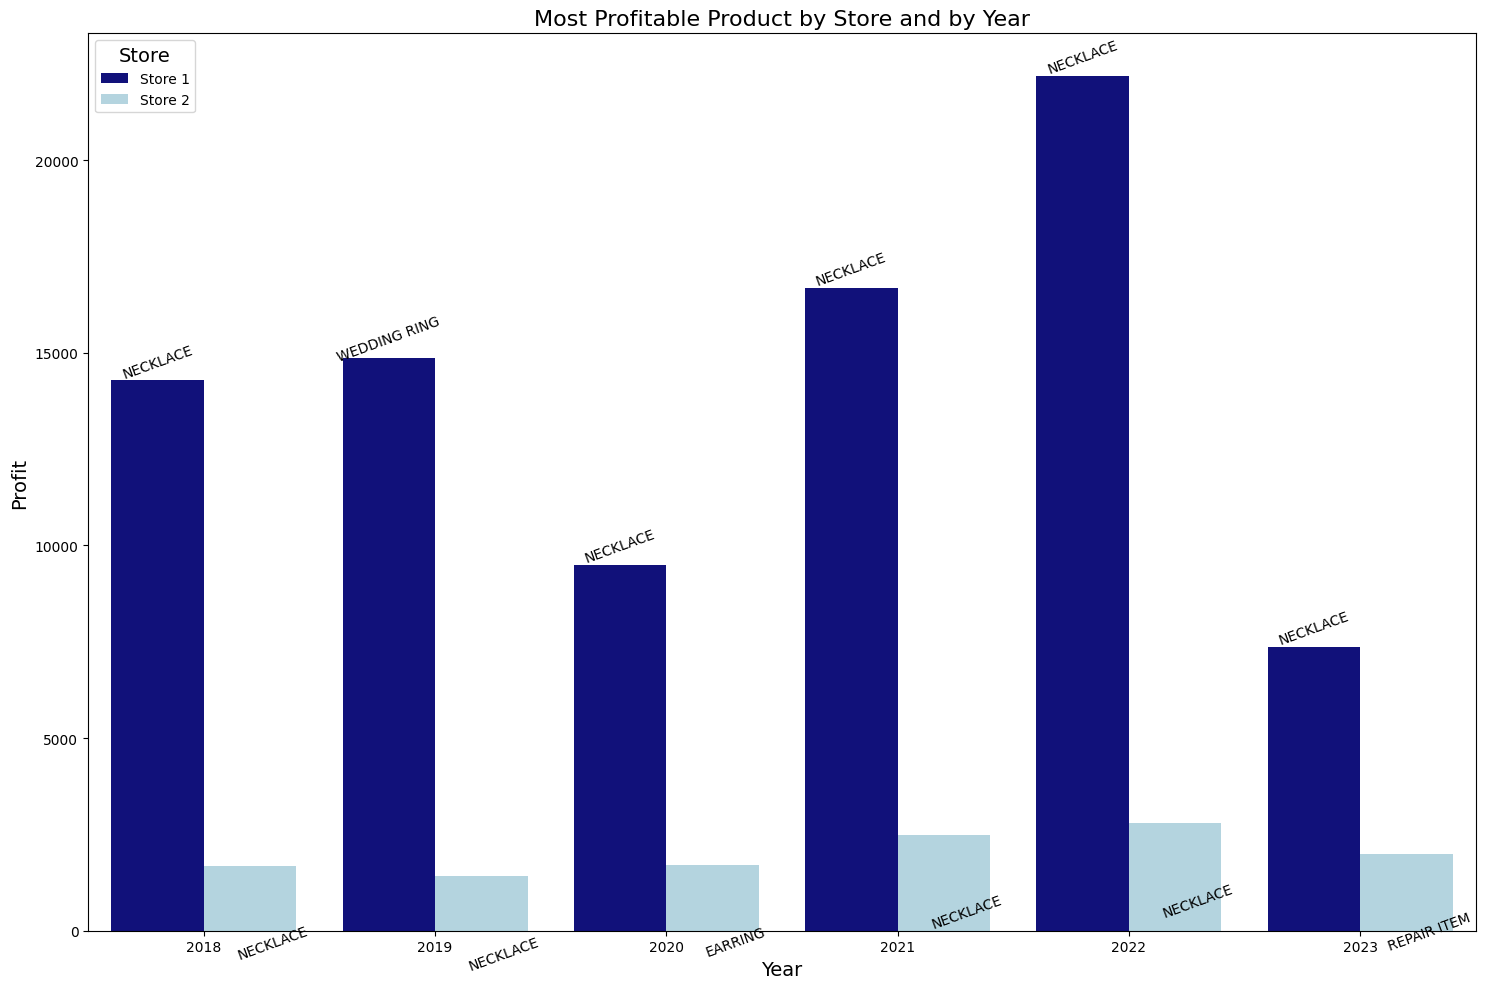

In [285]:
# Plotting the data
plt.figure(figsize=(15, 10))
sns.barplot(data=max_profit_product, x='YEAR', y='PROFIT', hue='Store_ID', errorbar=None, estimator=sum, palette=store_colors)

plt.title('Most Profitable Product by Store and by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Profit', fontsize=14)
plt.legend(title='Store', title_fontsize='14', loc='upper left', labels=['Store 1', 'Store 2'])

# Displaying the products as text on each bar
for index, value in enumerate(max_profit_product['PROFIT']):
    plt.text(max_profit_product['YEAR'].iloc[index] - 2018.2 + 0.5 * (max_profit_product['Store_ID'].iloc[index] - 1),
             value - 2000 if max_profit_product['Store_ID'].iloc[index] == 2 else value + 500,
             max_profit_product['PRODUCT'].iloc[index], 
             ha='center', 
             va='center', 
             rotation=20, 
             color='black', 
             fontsize=10)

plt.tight_layout()
plt.show()

### Most Profit Material

In [286]:
# Grouping and sorting to get the most profitable product for each store per year
max_profit_material = (sales.groupby(['Store_ID', 'YEAR', 'MATERIAL'])
                      .agg({'PROFIT': 'sum'})
                      .reset_index()
                      .sort_values(by=['Store_ID', 'YEAR', 'PROFIT'], ascending=[True, True, False])
                      .drop_duplicates(subset=['Store_ID', 'YEAR']))

max_profit_material1 = max_profit_material[max_profit_material['Store_ID'] == 1]
max_profit_material2 = max_profit_material[max_profit_material['Store_ID'] == 2]

In [287]:
display(max_profit_material1)

Store_ID  YEAR  MATERIAL        PROFIT
7           1  2018  GOLD 800  23556.004324
32          1  2019  GOLD 800  31335.295717
56          1  2020  GOLD 800  22297.919164
78          1  2021  GOLD 800  37918.513642
100         1  2022  GOLD 800  51127.022828
125         1  2023  GOLD 800  19161.826806

In [288]:
display(max_profit_material2)

Store_ID  YEAR    MATERIAL       PROFIT
153         2  2018  SILVER 925  3433.632419
171         2  2019  SILVER 925  3017.501486
189         2  2020  SILVER 925  3372.360578
205         2  2021  SILVER 925  4364.411229
221         2  2022  SILVER 925  5141.516736
236         2  2023  SILVER 925  2928.920379

# Seller Performance

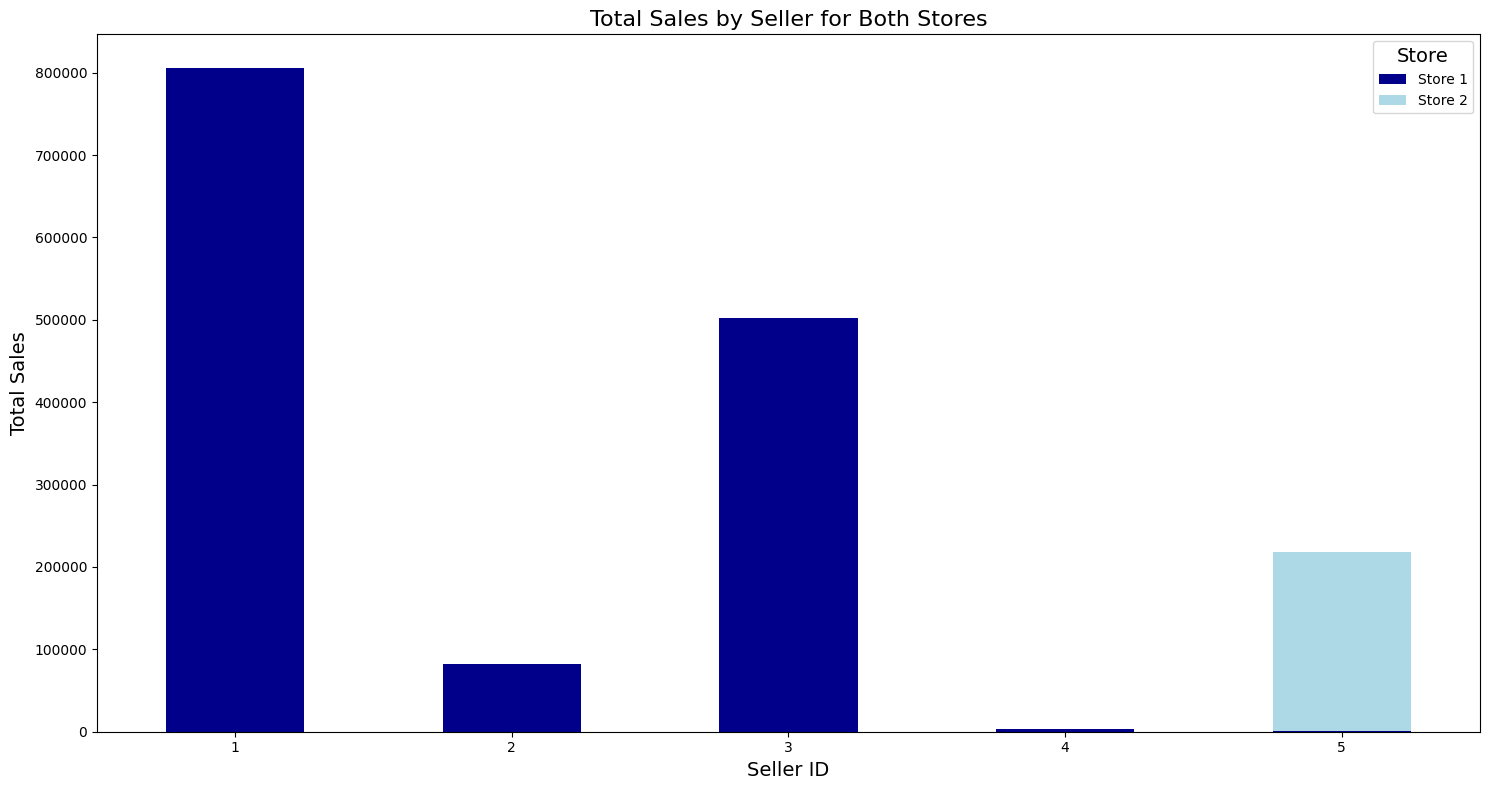

In [289]:
# Grouping by SELLER and Store_ID to get total sales for each seller in each store
seller_sales = sales.groupby(['SELLER', 'Store_ID'])['TOTAL_SALES'].sum().unstack().fillna(0)

# Plotting the stacked bar chart
seller_sales.plot(kind='bar', stacked=True, color=['darkblue', 'lightblue'], figsize=(15, 8))

plt.title('Total Sales by Seller for Both Stores', fontsize=16)
plt.xlabel('Seller ID', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.legend(title='Store', title_fontsize='14', labels=['Store 1', 'Store 2'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Seller Performence over the Year's

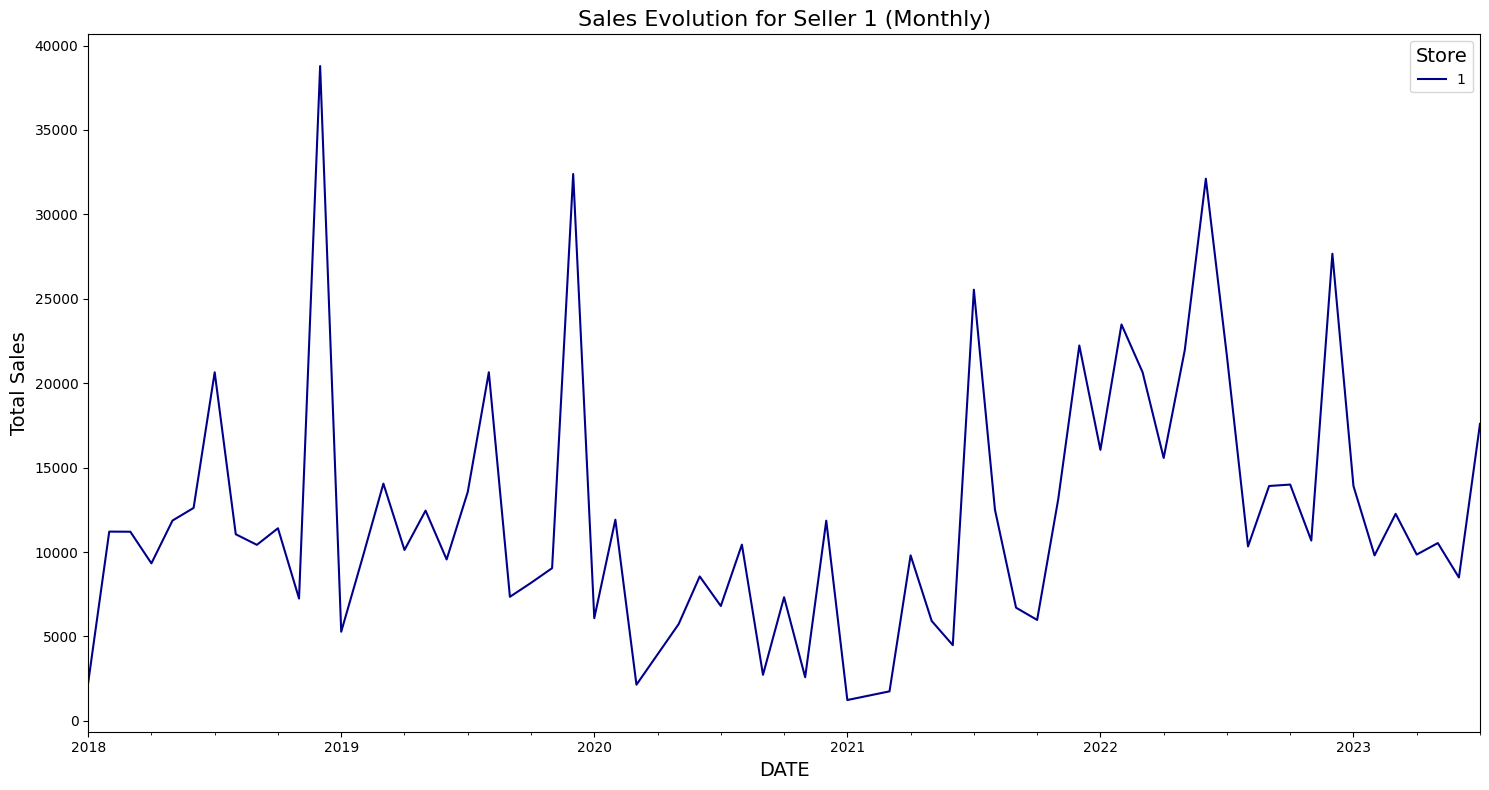

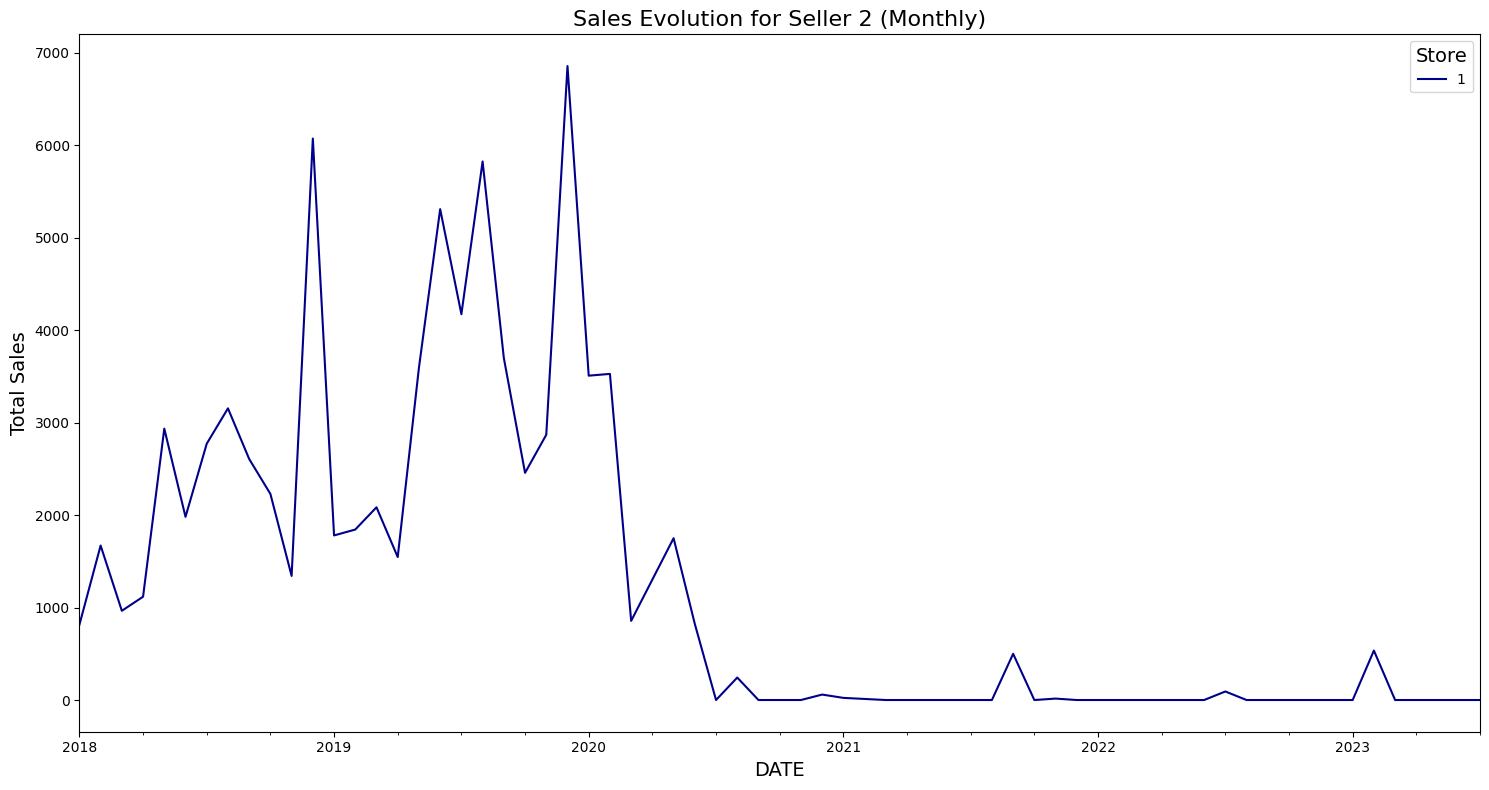

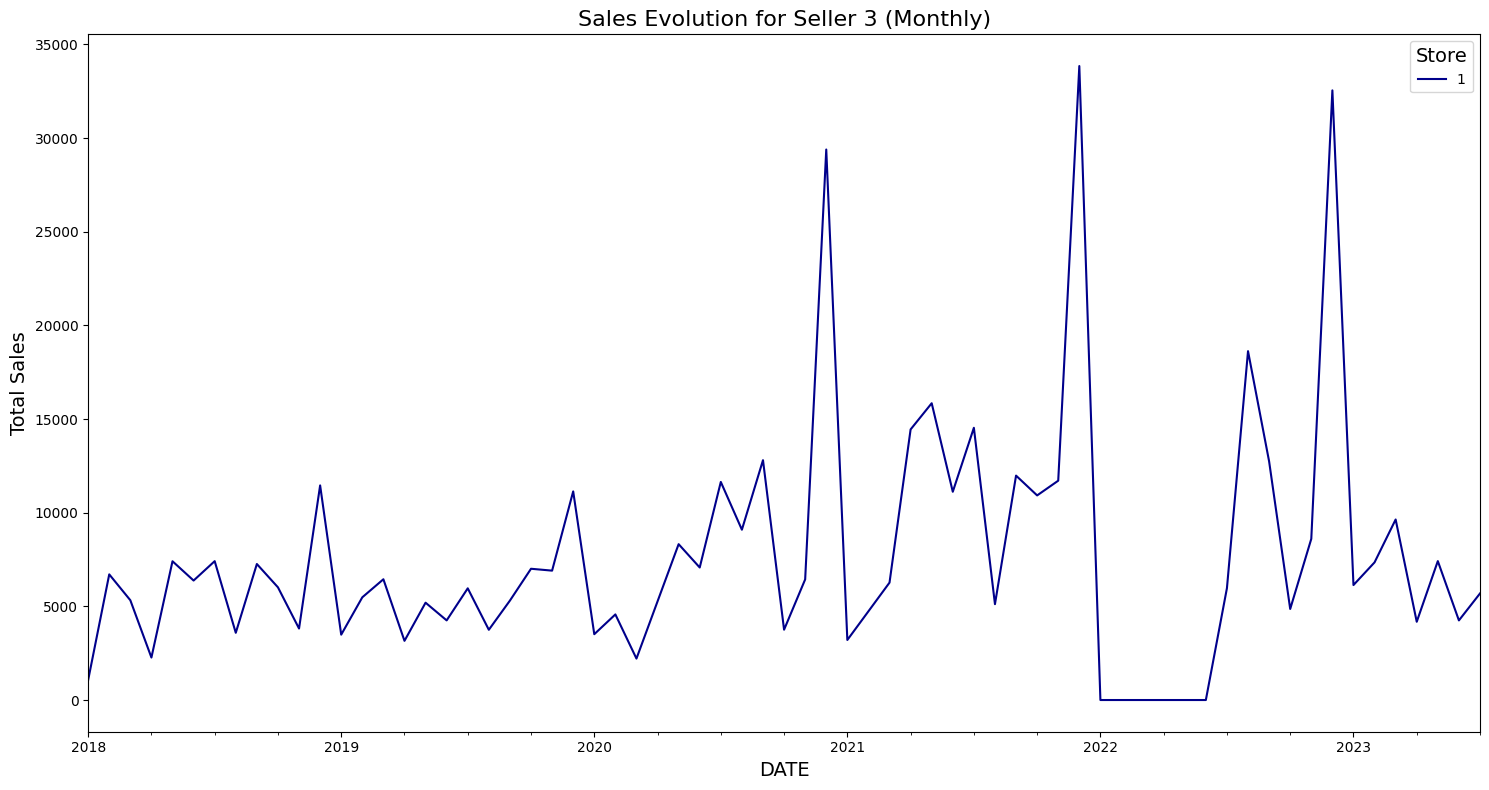

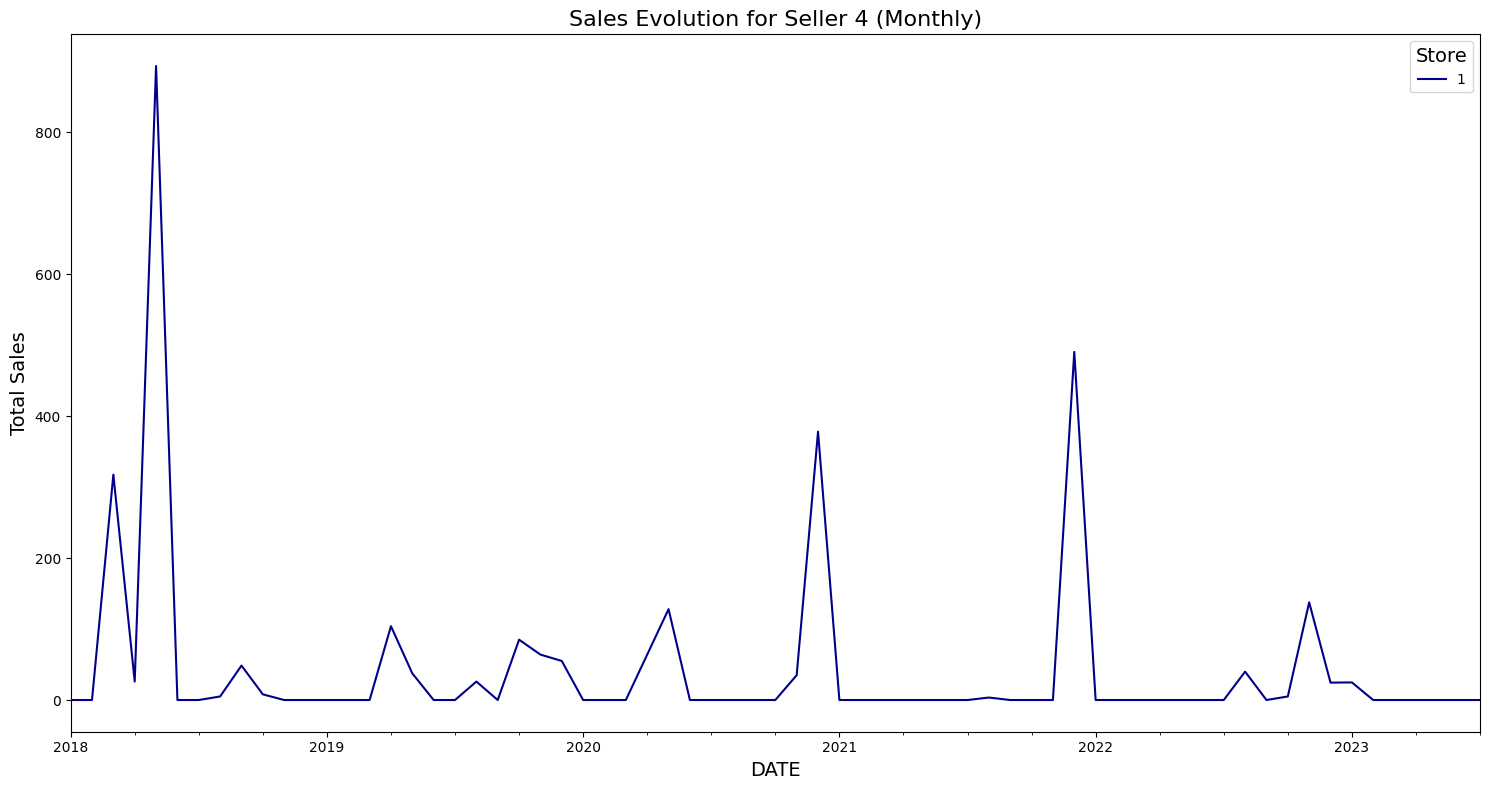

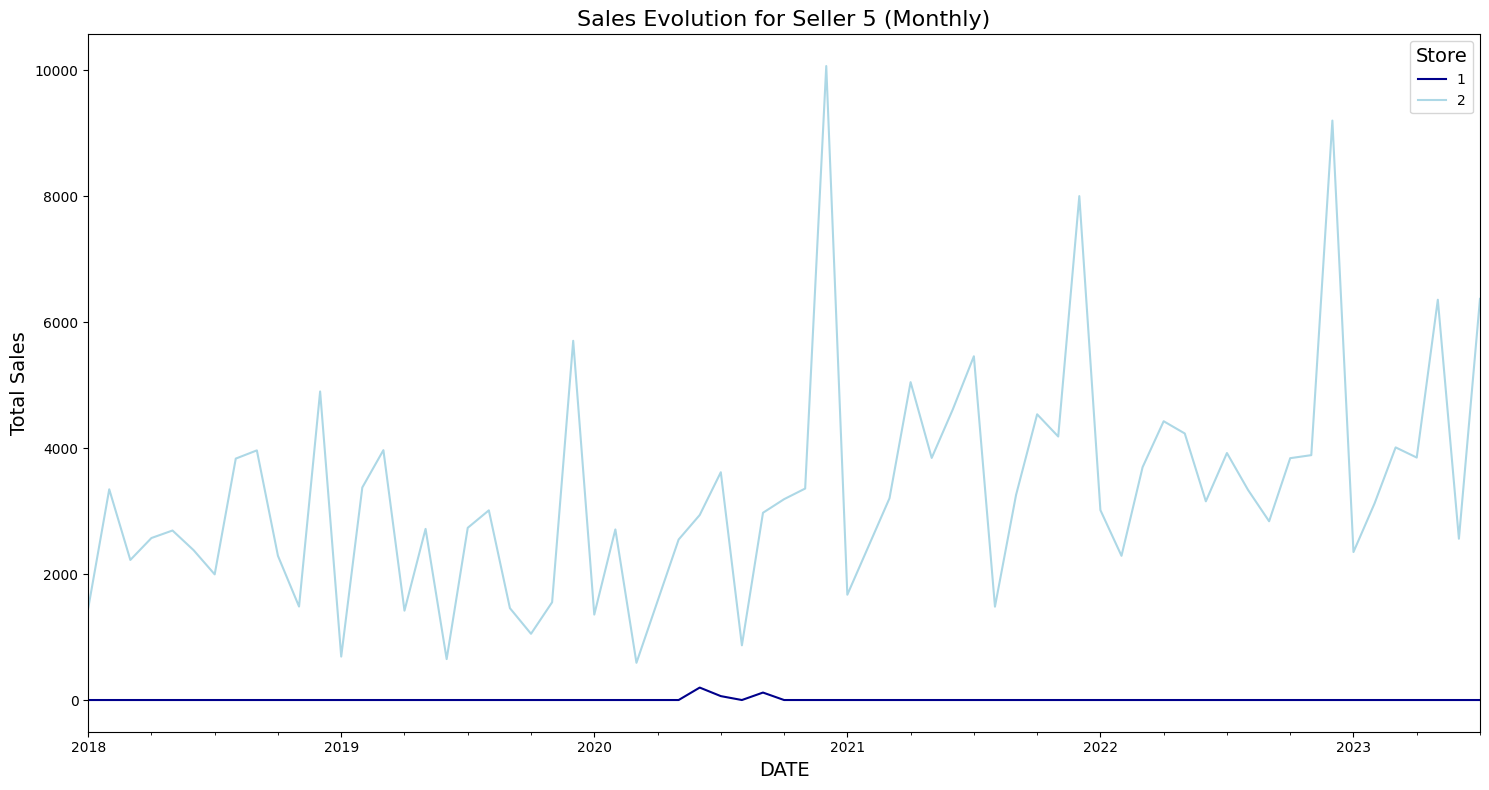

In [290]:
# Grouping by SELLER, Store_ID, and resampled DATE (monthly)
seller_sales_time = sales.groupby(['SELLER', 'Store_ID', sales['DATE'].dt.to_period("M")])['TOTAL_SALES'].sum().reset_index()

# Pivoting the data to make it suitable for a line plot
pivot_sales = seller_sales_time.pivot_table(index='DATE', columns=['SELLER', 'Store_ID'], values='TOTAL_SALES').fillna(0)

# Sort sellers numerically
sellers = sorted(sales['SELLER'].unique(), key=int)


for seller in sellers:
    # Filtering pivot_sales for the current seller
    seller_data = pivot_sales[seller]
    
    # Plotting the line plot for the current seller
    seller_data.plot(figsize=(15, 8), color=[store_colors[store] for store in seller_data.columns])
    
    plt.title(f'Sales Evolution for Seller {seller} (Monthly)', fontsize=16)
    plt.xlabel('DATE', fontsize=14)
    plt.ylabel('Total Sales', fontsize=14)
    plt.legend(title='Store', title_fontsize='14', labels=seller_data.columns)
    plt.tight_layout()
    plt.show()


# Cross Selling Anciliry Products 

*Cross-selling* refers to the practice of selling an additional product or service to an existing customer. In terms of data analysis, we typically look for patterns in the data where customers who purchase one product also tend to purchase another. Here's how we can approach cross-selling or upselling analysis using this dataset:

*Basket Analysis:*

A common approach to identify cross-selling opportunities is through basket analysis. This involves looking at combinations of products that frequently appear together in a single transaction.
The association rule mining technique, like the Apriori algorithm, is often used to identify these product combinations.

How to do it:

First, we transform data so that each transaction (or invoice) is a row and each product is a column. The values in the cells would indicate the quantity of each product in the transaction.
Next, we use an algorithm like Apriori to identify frequent product sets and create association rules.
From these rules, you can identify cross-selling opportunities. For instance, if many customers who buy product A also buy product B, but not many customers who buy product B also buy product A, there might be an opportunity to cross-sell product B to customers buying product A.

In [291]:
# Transforming the dataset for basket analysis
basket = sales.groupby(['Sales_ID', 'PRODUCT'])['QTD'].sum().unstack().reset_index().fillna(0)

# Converting quantity values to True (purchased) or False (not purchased)
basket_set = basket.applymap(lambda x: True if x > 0 else False)
basket_set.drop('Sales_ID', inplace=True, axis=1)

basket_set.head()

PRODUCT  ACESSORIES  ADVERTISING  ALARM CLOCK    BAG  BATTERY  BRACELET  \
0             False        False        False  False    False     False   
1             False        False        False  False    False     False   
2             False        False        False  False    False     False   
3             False        False        False  False    False     False   
4             False        False        False  False    False     False   

PRODUCT  BRACELET   BRACELET ITEM  BRACELET WATCH  CHARM  ...  RELIGIOUS ITEM  \
0             True          False           False  False  ...           False   
1            False          False           False   True  ...           False   
2            False          False           False  False  ...           False   
3            False          False           False  False  ...           False   
4            False          False           False  False  ...           False   

PRODUCT  REPAIR ITEM   RING  SERVICES  SHIPPING  SMART WATCHES  STONE  \
0              False  False     False     False          False  False   
1              False  False     False     False          False  False   
2              False  False     False     False          False  False   
3              False  False     False     False          False  False   
4              False  False     False     False          False  False   

PRODUCT  WATCH ITEM  WATCHES  WEDDING RING  
0             False    False         False  
1             False    False         False  
2             False    False         False  
3             False    False         False  
4             False     True         False  

[5 rows x 59 columns]

In [292]:
# Applying the Apriori algorithm
frequent_itemsets = apriori(basket_set, min_support=0.01, use_colnames=True)

# Sorting by support
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

frequent_itemsets.head()

support       itemsets
0   0.193183      (BATTERY)
11  0.175155  (REPAIR ITEM)
7   0.116888      (EARRING)
10  0.105989     (NECKLACE)
1   0.089758    (BRACELET )

In [293]:
#Create Association Rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values(by='lift', ascending=False)
rules

antecedents       consequents  antecedent support  consequent support  \
2        (NECKLACE)           (CHARM)            0.105989            0.073909   
3           (CHARM)        (NECKLACE)            0.073909            0.105989   
1  (BRACELET WATCH)         (BATTERY)            0.066309            0.193183   
0         (BATTERY)  (BRACELET WATCH)            0.193183            0.066309   

    support  confidence      lift  leverage  conviction  zhangs_metric  
2  0.013992    0.132018  1.786213  0.006159    1.066947       0.492339  
3  0.013992    0.189318  1.786213  0.006159    1.102790       0.475284  
1  0.016820    0.253665  1.313078  0.004010    1.081038       0.255364  
0  0.016820    0.087069  1.313078  0.004010    1.022740       0.295520

*Explain the dataframe*
- *antecedents*: The item (or set of items) that is frequently bought first.
- *consequents*: The item (or set of items) that is frequently bought after the "antecedents" item.
- *antecedent* support: Proportion of transactions that contain the "antecedents" item.
- *consequent* support: Proportion of transactions that contain the "consequents" item.
- *support*: Proportion of transactions that contain both "antecedents" and "consequents" items.
- *confidence*: Probability of a customer purchasing the "consequents" item given that they have already purchased the "antecedents" item.
- *lift*: Indicates how much more likely the "consequents" is to be bought when the "antecedents" is purchased, compared to the likelihood of buying the "consequents" on its own. A "lift" value greater than 1 indicates a significant relationship between the two items.
- *leverage*: The difference between the probability of both items being bought together and the expected probability if they were independent. Positive values indicate a positive association between the items.
- *conviction*: Measures the dependency of the "consequents" on the "antecedents". A high value indicates that the "consequents" is highly dependent on the "antecedents".
- *zhangs_metric*: A metric that measures the difference between the observed and expected probability of both items occurring together.

*Interpretation of the results*

Customers who purchase a "CHARM" are 1.79 times more likely to purchase a "NECKLACE" compared to customers who don't purchase a "CHARM".
Customers who purchase a "BRACELET WATCH" are 1.31 times more likely to purchase a "BATTERY" compared to customers who don't purchase a "BRACELET WATCH".

In [294]:
#pickle table rules to export to streamlit App
import pickle 
rules.to_pickle("crossproducts.pkl")

# External Factors

## Weather Conditions

Given that both stores are traditional retail shops located on the street, it will be important to understand if meteorological factors have an impact on sales

In [295]:
# Descriptive statistics meteorological factors
descriptive_stats = sales[['TOTAL_SALES','TEMPERATURE', 'PRECIPITATION', 'CLOUDCOVER(%)']].describe().round(2)
descriptive_stats


TOTAL_SALES  TEMPERATURE  PRECIPITATION  CLOUDCOVER(%)
count     43335.00     43335.00       43335.00       43335.00
mean         37.18        18.68           0.06          33.43
std         100.90         4.37           0.21          29.06
min        -670.00         7.63           0.00           0.00
25%           4.00        15.02           0.00           6.83
50%          15.00        18.28           0.00          26.92
75%          32.00        22.11           0.00          53.25
max        3500.00        35.75           4.37         100.00

Correlation between sales and meteorological factors

In [296]:
correlation_matrix = sales[['TOTAL_SALES', 'TEMPERATURE', 'PRECIPITATION', 'CLOUDCOVER(%)']].corr()
correlation_matrix

TOTAL_SALES  TEMPERATURE  PRECIPITATION  CLOUDCOVER(%)
TOTAL_SALES       1.000000    -0.001942       0.000660       0.011077
TEMPERATURE      -0.001942     1.000000      -0.158981      -0.376032
PRECIPITATION     0.000660    -0.158981       1.000000       0.394257
CLOUDCOVER(%)     0.011077    -0.376032       0.394257       1.000000

Based on these correlations, it appears that meteorological factors do not have a strong linear relationship with sales. However, to have a clearer visualization, we can plot scatter plots between sales and each of the meteorological factors

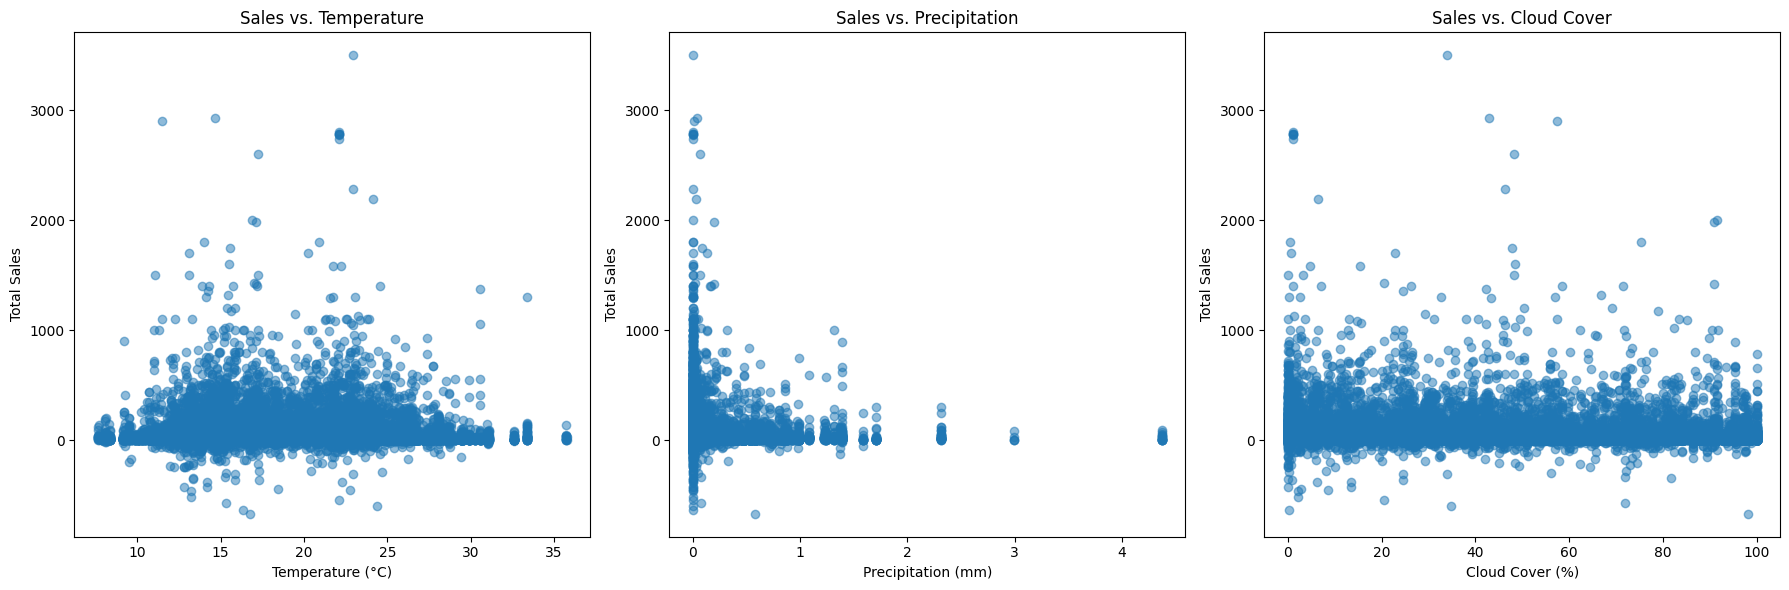

In [297]:
# Plotting scatter plots for sales vs. meteorological factors
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Sales vs. Temperature
axes[0].scatter(sales['TEMPERATURE'], sales['TOTAL_SALES'], alpha=0.5)
axes[0].set_title('Sales vs. Temperature')
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Total Sales')

# Sales vs. Precipitation
axes[1].scatter(sales['PRECIPITATION'], sales['TOTAL_SALES'], alpha=0.5)
axes[1].set_title('Sales vs. Precipitation')
axes[1].set_xlabel('Precipitation (mm)')
axes[1].set_ylabel('Total Sales')

# Sales vs. Cloud Cover
axes[2].scatter(sales['CLOUDCOVER(%)'], sales['TOTAL_SALES'], alpha=0.5)
axes[2].set_title('Sales vs. Cloud Cover')
axes[2].set_xlabel('Cloud Cover (%)')
axes[2].set_ylabel('Total Sales')

plt.tight_layout()
plt.show()

*Interpretation of the results*

- Sales vs. Temperature: No clear trend is observed, which is consistent with the near-zero correlation.
- Sales vs. Precipitation: Most points are concentrated at low precipitation values. No clear trend between precipitation and sales is observed.
- Sales vs. Cloud Cover: The dispersion is wide, and no clear trend is observed.

The plots confirm the conclusions drawn from the correlations. It appears that in this dataset, meteorological factors do not have a direct and linear impact on sales.

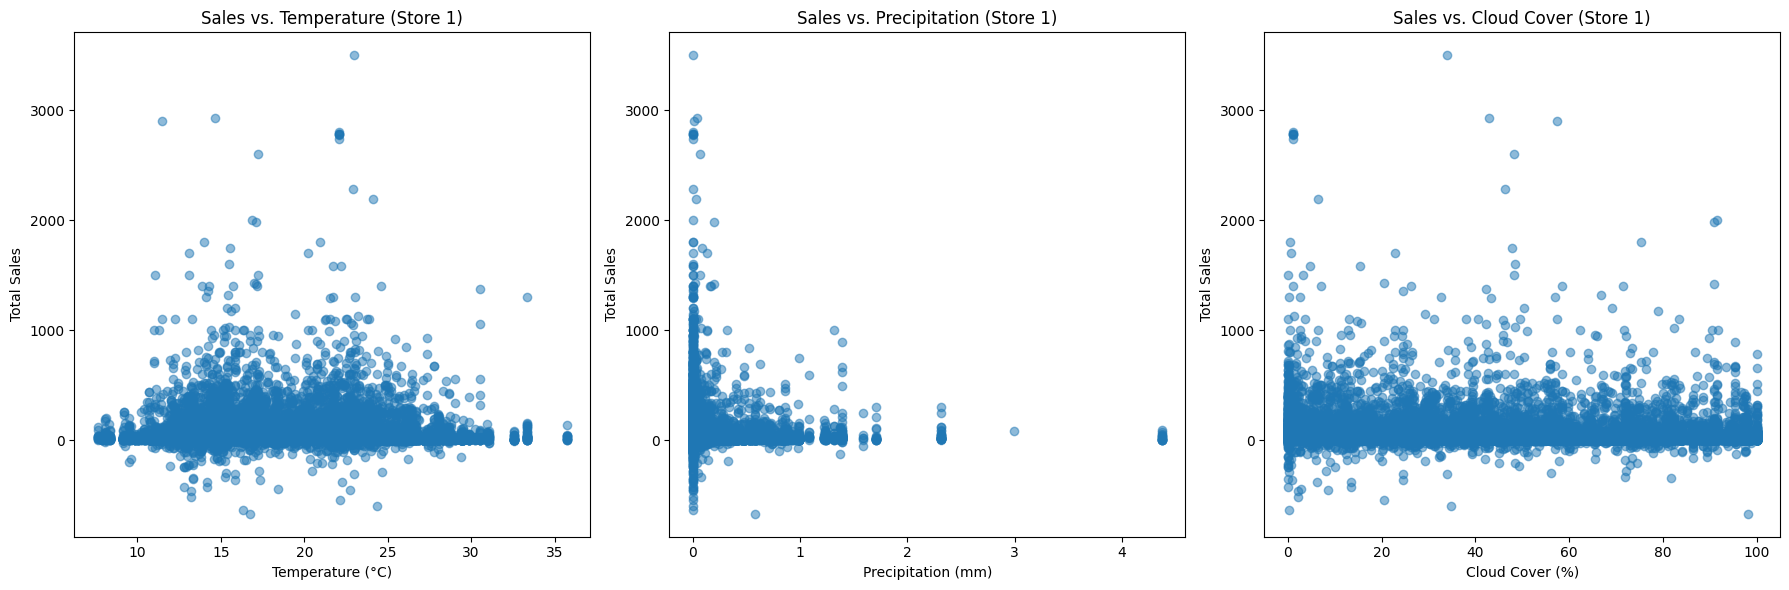

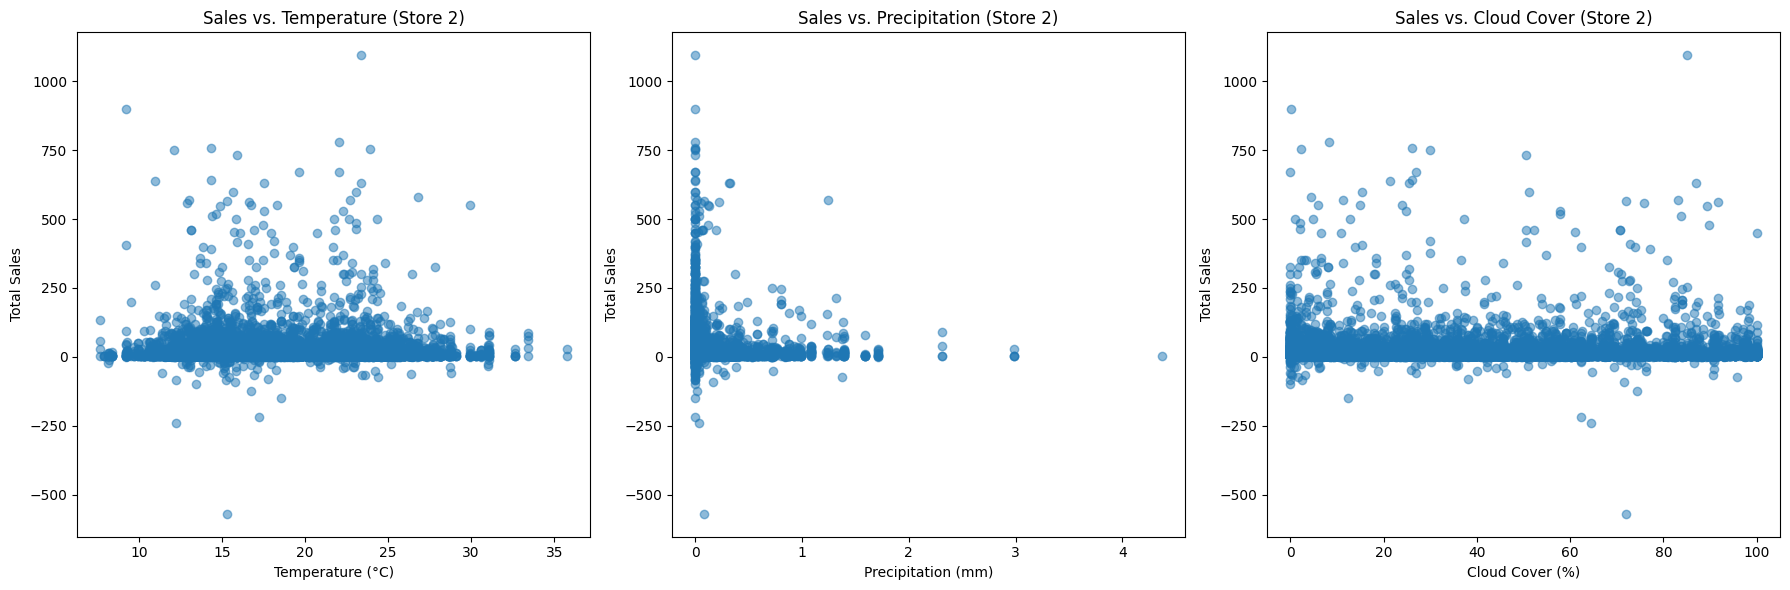

In [298]:
# Filtering data for Store 1 and Store 2
sales_store1 = sales[sales['Store_ID'] == 1]
sales_store2 = sales[sales['Store_ID'] == 2]

# Function to plot scatter plots for a given dataset and store name
def plot_scatter(sales_data, store_name):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # Sales vs. Temperature
    axes[0].scatter(sales_data['TEMPERATURE'], sales_data['TOTAL_SALES'], alpha=0.5)
    axes[0].set_title(f'Sales vs. Temperature ({store_name})')
    axes[0].set_xlabel('Temperature (°C)')
    axes[0].set_ylabel('Total Sales')

    # Sales vs. Precipitation
    axes[1].scatter(sales_data['PRECIPITATION'], sales_data['TOTAL_SALES'], alpha=0.5)
    axes[1].set_title(f'Sales vs. Precipitation ({store_name})')
    axes[1].set_xlabel('Precipitation (mm)')
    axes[1].set_ylabel('Total Sales')

    # Sales vs. Cloud Cover
    axes[2].scatter(sales_data['CLOUDCOVER(%)'], sales_data['TOTAL_SALES'], alpha=0.5)
    axes[2].set_title(f'Sales vs. Cloud Cover ({store_name})')
    axes[2].set_xlabel('Cloud Cover (%)')
    axes[2].set_ylabel('Total Sales')

    plt.tight_layout()
    plt.show()


plot_scatter(sales_store1, "Store 1")
plot_scatter(sales_store2, "Store 2")


*Interpretation of the results*

Impact of Precipitation: For both stores, sales seem to be higher when there's little to no precipitation. This is a common observation in retail, as customers often prefer not to shop in adverse weather conditions.

Temperature and Cloud Cover: Neither temperature nor cloud cover shows a strong correlation with sales for either store. Other factors might be influencing sales more strongly, or the effects of these factors might be more nuanced and require deeper analysis.

## Receipt of the consumer's salary and its impact on sales.

The period after salary payments can indeed influence consumer buying behavior.

Let's proceed as follows:

- Segmentation by Payment Date: First, we will segment the data into two groups: the days close to the payment period (days 21 to 31 of each month) and the other days.

- Statistical Analysis: Next, we will conduct a statistical test to compare the sales averages between these two groups, in order to determine if there is a significant difference.

- Visualization: We will also visualize the daily sales throughout the month to observe any trends or patterns that may emerge around the payment period.

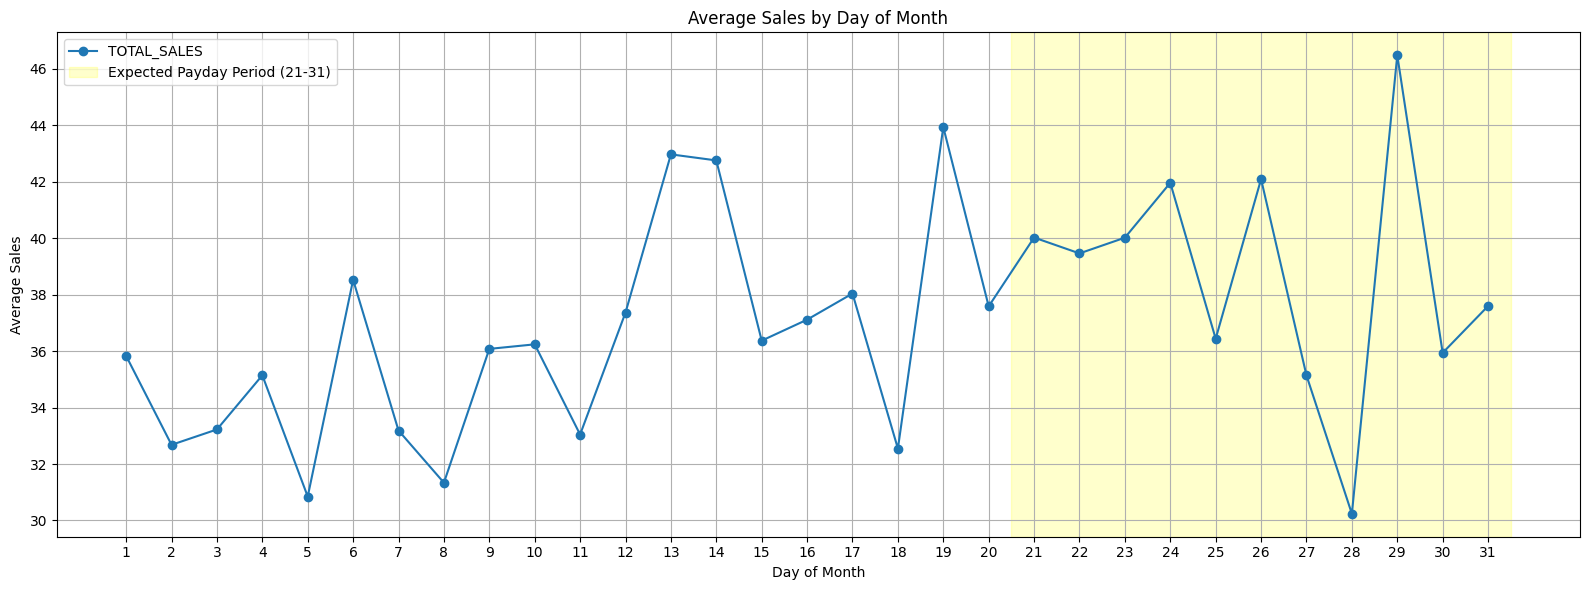

In [299]:
# Extracting day of the month from the DATE column
sales['DAY_OF_MONTH'] = sales['DATE'].dt.day

# Calculating average sales for each day of the month
average_sales_by_day = sales.groupby('DAY_OF_MONTH').mean(numeric_only=True)['TOTAL_SALES']

# Plotting average sales by day of the month
plt.figure(figsize=(16, 6))
average_sales_by_day.plot(kind='line', marker='o', linestyle='-')
plt.axvspan(20.5, 31.5, color='yellow', alpha=0.2, label='Expected Payday Period (21-31)')
plt.title('Average Sales by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Average Sales')
plt.legend()
plt.grid(True)
plt.xticks(list(range(1, 32)))
plt.tight_layout()
plt.show()

### Segmentation by Payment Date and Visualization Store 1 & 2 

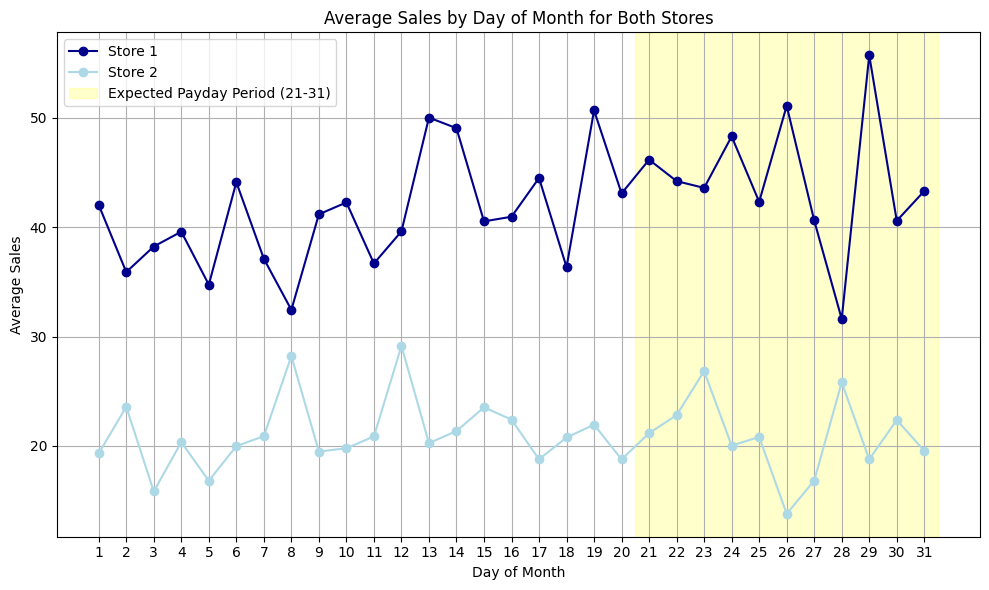

In [300]:
# Plotting average sales by day of the month for both stores on the same plot
plt.figure(figsize=(10, 6))

# Segmenting the data by store
store_1_sales = sales[sales['Store_ID'] == 1].copy()
store_2_sales = sales[sales['Store_ID'] == 2].copy()

# Extracting day of the month for each store
store_1_sales['DAY_OF_MONTH'] = store_1_sales['DATE'].dt.day
store_2_sales['DAY_OF_MONTH'] = store_2_sales['DATE'].dt.day

# Calculating average sales for each day of the month for each store
average_sales_by_day_store_1 = store_1_sales.groupby('DAY_OF_MONTH').mean(numeric_only=True)['TOTAL_SALES']
average_sales_by_day_store_2 = store_2_sales.groupby('DAY_OF_MONTH').mean(numeric_only=True)['TOTAL_SALES']

average_sales_by_day_store_1.plot(kind='line', marker='o', linestyle='-', color='darkblue', label='Store 1')
average_sales_by_day_store_2.plot(kind='line', marker='o', linestyle='-', color='lightblue', label='Store 2')

plt.axvspan(20.5, 31.5, color='yellow', alpha=0.2, label='Expected Payday Period (21-31)')
plt.title('Average Sales by Day of Month for Both Stores')
plt.xlabel('Day of Month')
plt.ylabel('Average Sales')
plt.legend()
plt.grid(True)
plt.xticks(list(range(1, 32)))

plt.tight_layout()
plt.show()


*Interpert of the results*

In both graphs, the period highlighted in yellow (days 21 to 31) represents the expected payday period. This visualization allows us to observe sales trends throughout the month and see if there are noticeable spikes or changes around the payday period.

From a preliminary observation, it seems there might be some slight increase in sales towards the end of the month for Store 1, but the pattern is not very pronounced for Store 2. 

To better understand, we will now conduct a statistical analysis to compare the average sales between the days of the payment period and the other days.

### T-Test

#### Hypothesis

H0 (Null Hypothesis): The average sales during the payday period (days 21-31) is equal to the average sales during the other days of the month.

H1 (Alternative Hypothesis): The average sales during the payday period (days 21-31) is not equal to the average sales during the other days of the month.

In [301]:
# Segmenting sales data for Store 1 based on the payday period (21-31) and other days
store_1_payday_sales = store_1_sales[store_1_sales['DAY_OF_MONTH'].between(21, 31)]['TOTAL_SALES']
store_1_non_payday_sales = store_1_sales[~store_1_sales['DAY_OF_MONTH'].between(21, 31)]['TOTAL_SALES']

# Performing the t-test for Store 1
t_stat_store_1, p_val_store_1 = ttest_ind(store_1_payday_sales, store_1_non_payday_sales, equal_var=False)

# Segmenting sales data for Store 2 based on the payday period (21-31) and other days
store_2_payday_sales = store_2_sales[store_2_sales['DAY_OF_MONTH'].between(21, 31)]['TOTAL_SALES']
store_2_non_payday_sales = store_2_sales[~store_2_sales['DAY_OF_MONTH'].between(21, 31)]['TOTAL_SALES']

# Performing the t-test for Store 2
t_stat_store_2, p_val_store_2 = ttest_ind(store_2_payday_sales, store_2_non_payday_sales, equal_var=False)

t_stats_and_p_values = {
    'Store 1': (t_stat_store_1, p_val_store_1),
    'Store 2': (t_stat_store_2, p_val_store_2)
}

t_stats_and_p_values


{'Store 1': (2.295693494611961, 0.02170291185160541),
 'Store 2': (-0.09461037314507473, 0.9246267197310155)}

*Interpretation of the results*

- *For Store 1*:
The p-value of 0.0217 is less than the commonly used significance level of 0.05. This means that we reject the null hypothesis (H0) for Store 1. The sales during the payday period (days 21-31) are significantly different than the sales during the other days of the month. Given that the t-statistic is positive, the sales during the payday period are higher on average than those on other days.

- *For Store 2*:
The p-value of 0.9246 is much greater than 0.05. This means we fail to reject the null hypothesis (H0) for Store 2. There's no significant evidence to suggest that the average sales during the payday period differ from the sales on other days for Store 2.

This suggests that the consumers of Store 1 are influenced by the payday period in their buying behavior, while those of Store 2 are not.

# Consumer Profile

#### Average Sales by Gender

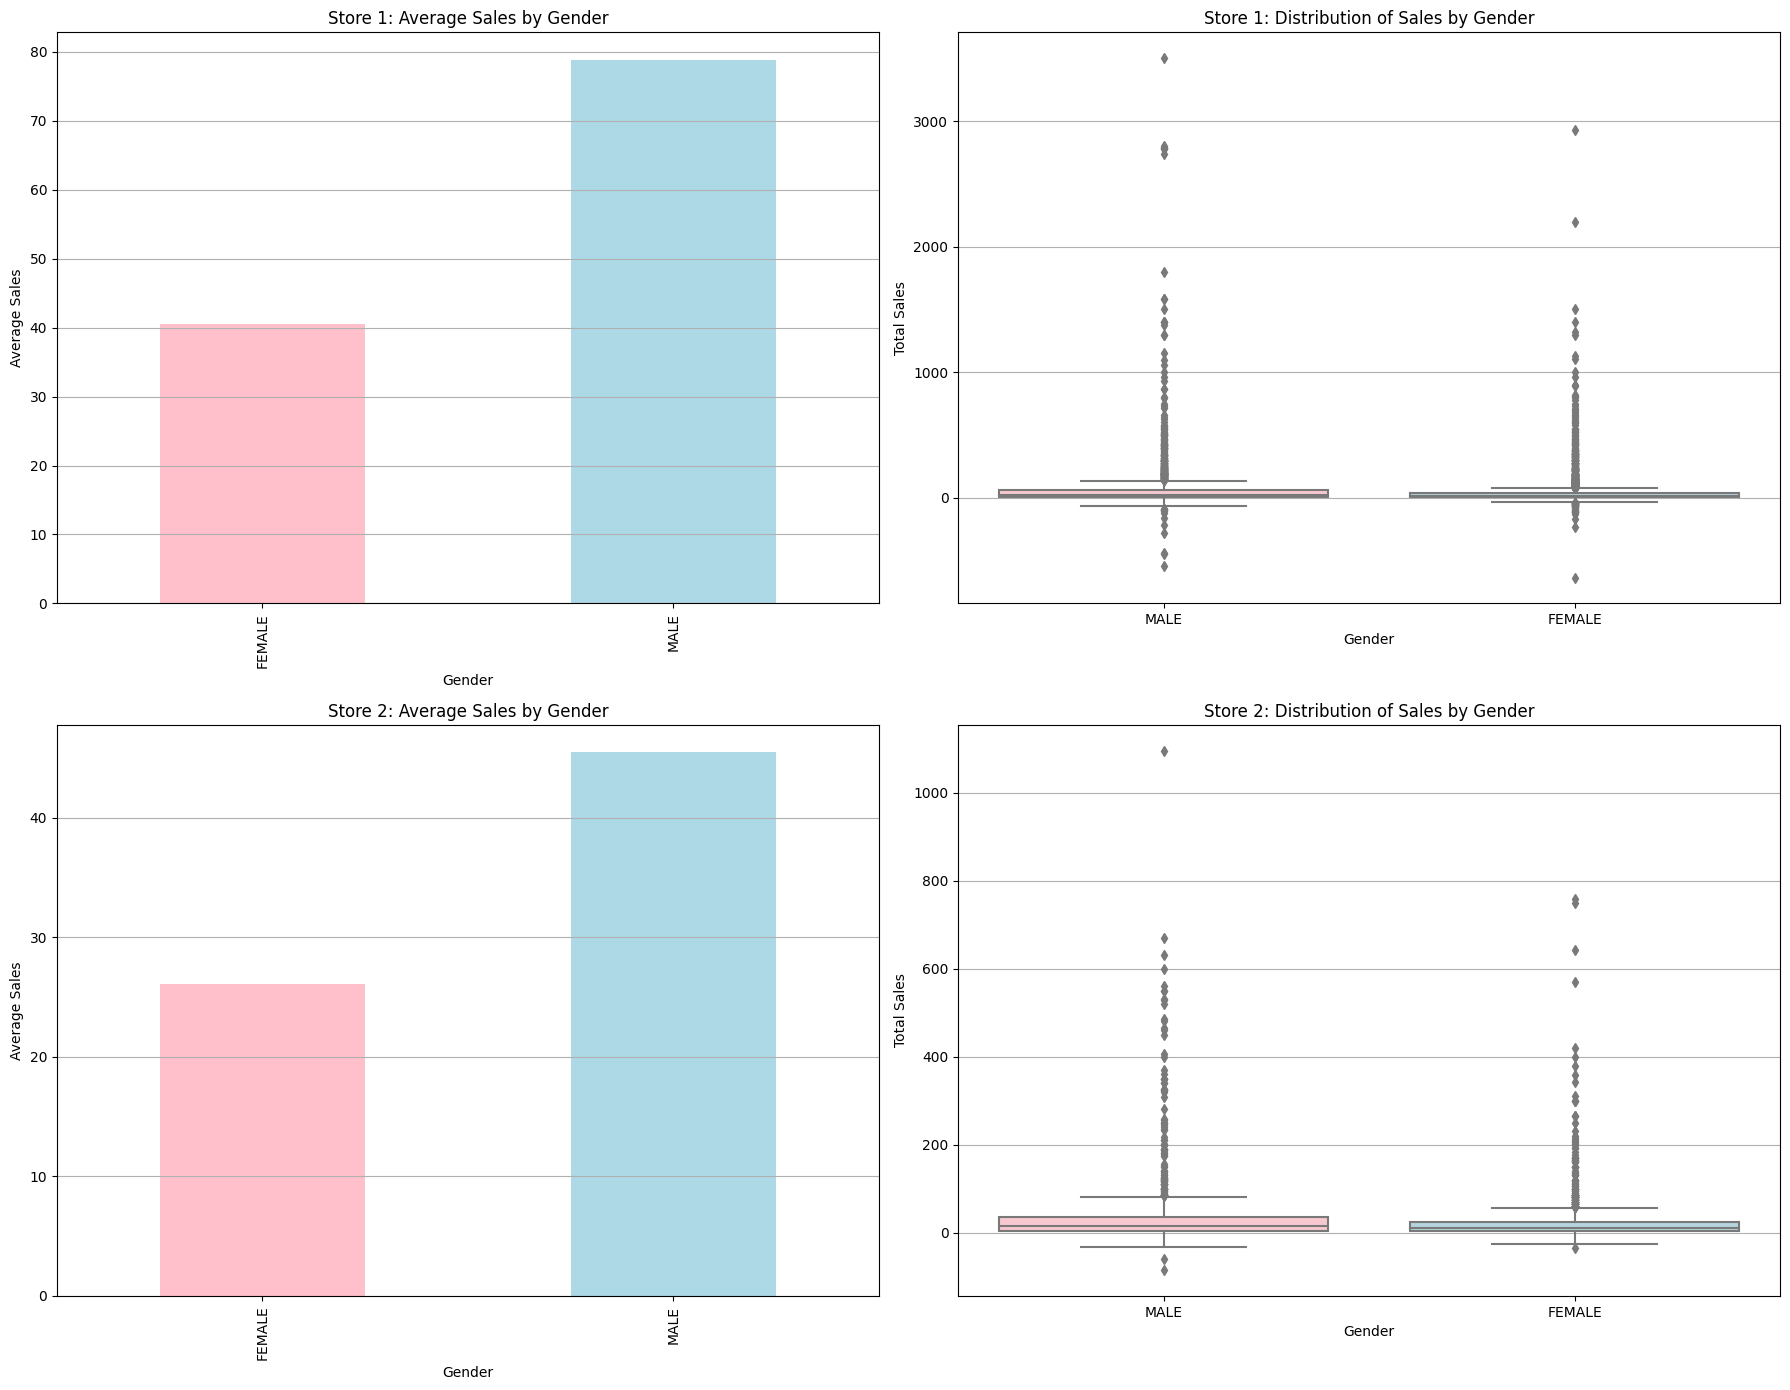

In [302]:
# Segmenting the sales data based on gender
store_1_gender_data = store_1_sales[store_1_sales['GENDER'].isin(['MALE', 'FEMALE'])]
store_2_gender_data = store_2_sales[store_2_sales['GENDER'].isin(['MALE', 'FEMALE'])]

# Plotting
plt.figure(figsize=(18, 14))

# Function to plot sales by gender for a store
def plot_sales_by_gender(store_data, title_prefix, position):
    avg_sales = store_data.groupby('GENDER').mean(numeric_only=True)['TOTAL_SALES']
    plt.subplot(2, 2, position)
    avg_sales.plot(kind='bar', color=['pink', 'lightblue'])
    plt.title(f'{title_prefix}: Average Sales by Gender')
    plt.ylabel('Average Sales')
    plt.xlabel('Gender')
    plt.grid(axis='y')
    
    plt.subplot(2, 2, position+1)
    sns.boxplot(x='GENDER', y='TOTAL_SALES', data=store_data, palette=['pink', 'lightblue'])
    plt.title(f'{title_prefix}: Distribution of Sales by Gender')
    plt.ylabel('Total Sales')
    plt.xlabel('Gender')
    plt.grid(axis='y')

# Plotting for Store 1 and Store 2
plot_sales_by_gender(store_1_gender_data, 'Store 1', 1)
plot_sales_by_gender(store_2_gender_data, 'Store 2', 3)

plt.tight_layout()
plt.show()


*Interpretation of the results*

- Store 1:

- Average Sales by Gender: The average sales for males are higher than for females. This means that, on average, males tend to spend more in Store 1 than females.
- Distribution of Sales by Gender: The boxplots show that the median sales for males are higher than for females. The interquartile range (IQR, represented by the height of the boxes) for males is also broader, indicating more variability in their purchase amounts.

- Store 2:
- Average Sales by Gender: In Store 2, the average sales for males are again higher than for females.
- Distribution of Sales by Gender: The distribution for males in Store 2 is slightly more dispersed than for females, indicating a wider range of purchase amounts among males.

Resume:

In both stores, males tend to spend more on average than females.
Males also show a broader distribution in their purchase amounts, suggesting they have both lower and higher spending transactions more frequently than females.
This data suggests that marketing and inventory strategies in both stores could benefit from a focus on male customers, given their higher average spending and broader range of purchase values.

#### Purchase Frequency by Gender: How often, on average, did each gender make purchases? 

In [303]:
# Calculating purchase frequency and average purchase value for each gender in Store 1
store_1_gender_freq = store_1_gender_data.groupby('GENDER').size()
store_1_gender_avg_purchase = store_1_gender_data.groupby('GENDER').mean(numeric_only=True)['TOTAL_SALES'].round(2)

# Calculating purchase frequency and average purchase value for each gender in Store 2
store_2_gender_freq = store_2_gender_data.groupby('GENDER').size()
store_2_gender_avg_purchase = store_2_gender_data.groupby('GENDER').mean(numeric_only=True)['TOTAL_SALES'].round(2)

# Create a multi-level dataframe
purchase_gender  = pd.DataFrame({
    ('Store 1', 'Purchase Frequency'): store_1_gender_freq,
    ('Store 1', 'Average Purchase Value'): store_1_gender_avg_purchase,
    ('Store 2', 'Purchase Frequency'): store_2_gender_freq,
    ('Store 2', 'Average Purchase Value'): store_2_gender_avg_purchase
})

# Display the dataframe
purchase_gender

Store 1                                   Store 2  \
       Purchase Frequency Average Purchase Value Purchase Frequency   
GENDER                                                                
FEMALE               4207                  40.53               1333   
MALE                 1892                  78.86                772   

                               
       Average Purchase Value  
GENDER                         
FEMALE                  26.06  
MALE                    45.49

*Resume*

- Store 1:
Purchase Frequency:
FEMALE: 4,207 purchases
MALE: 1,892 purchases
Average Purchase Value:
FEMALE: 40.53€
MALE: 78.86€

- Store 2:
Purchase Frequency:
FEMALE: 1,333 purchases
MALE: 772 purchases
Average Purchase Value:
FEMALE: 26.06€
MALE: 45.49€

Observations:

In both stores, women purchase more frequently than men.
However, the average purchase value is higher for men in both stores.

##### T-Test

The next step would be to conduct a statistical analysis to determine whether the observed differences in sales or frequency are significant.

The hypotheses are:

- H0(Null Hypothesis): There is no significant difference in average sales between the genders.
- H1(Alternative Hypothesis): There is a significant difference in average sales between the genders.

In [304]:
# Performing the t-test for gender differences in sales for Store 1
store_1_female_sales = store_1_gender_data[store_1_gender_data['GENDER'] == 'FEMALE']['TOTAL_SALES']
store_1_male_sales = store_1_gender_data[store_1_gender_data['GENDER'] == 'MALE']['TOTAL_SALES']
t_stat_store_1_gender, p_val_store_1_gender = ttest_ind(store_1_female_sales, store_1_male_sales, equal_var=False)

# Performing the t-test for gender differences in sales for Store 2
store_2_female_sales = store_2_gender_data[store_2_gender_data['GENDER'] == 'FEMALE']['TOTAL_SALES']
store_2_male_sales = store_2_gender_data[store_2_gender_data['GENDER'] == 'MALE']['TOTAL_SALES']
t_stat_store_2_gender, p_val_store_2_gender = ttest_ind(store_2_female_sales, store_2_male_sales, equal_var=False)

t_stat_store_1_gender, p_val_store_1_gender, t_stat_store_2_gender, p_val_store_2_gender

(-6.840679098516757,
 1.0099390080651248e-11,
 -4.9901258386244605,
 7.047017679014008e-07)

*Interpretation*

Store 1: Thep-value is much less than 0.05, which indicates there's a statistically significant difference in sales between male and female customers in Store 1. The negative t-statistic suggests that females tend to have lower sales than males in this store.

Store 2: Similarly, the p-value  is also much less than 0.05, which means there's a statistically significant difference in sales between the genders in Store 2 as well. The negative t-statistic again suggests that females tend to have lower sales than males in this store.

In conclusion, for both stores, there's a statistically significant difference in sales between male and female customers, with females having lower sales than males. This provides a basis to further investigate factors that might be influencing these differences and potentially explore strategies to enhance sales to female customers.

# Social Media

In [305]:
feedback_data = pd.read_excel("SocialMedias.xlsx")
feedback_data

Data   ID  Store      Plataform  \
0    2017    1      1         Google   
1    2018    2      1         Google   
2    2018    3      1         Google   
3    2018    4      1         Google   
4    2023    5      1         Google   
..    ...  ...    ...            ...   
180  2018  181      2  Casamentos.pt   
181  2018  182      1  Casamentos.pt   
182  2017  183      1  Casamentos.pt   
183  2022  184      1  Casamentos.pt   
184  2014  185      1  Casamentos.pt   

                                               Comment  rating  
0    Here you can count on the friendliness and exc...       5  
1    I bought a special custom ring from another co...       1  
2    Excellent service. The product may take a whil...       4  
3    Excellent service, congratulations on your pat...       5  
4                                    Such friendliness       5  
..                                                 ...     ...  
180  We had an idea of what we wanted from seeing i...       5  
181  The staff is all very friendly and welcoming. ...       5  
182  I've known this place for several years, and t...       5  
183  They were very available and clarified all our...       5  
184  I recommend them for their professionalism tow...       5  

[185 rows x 6 columns]

c:\Users\USER\anaconda3\envs\projectjewelry\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


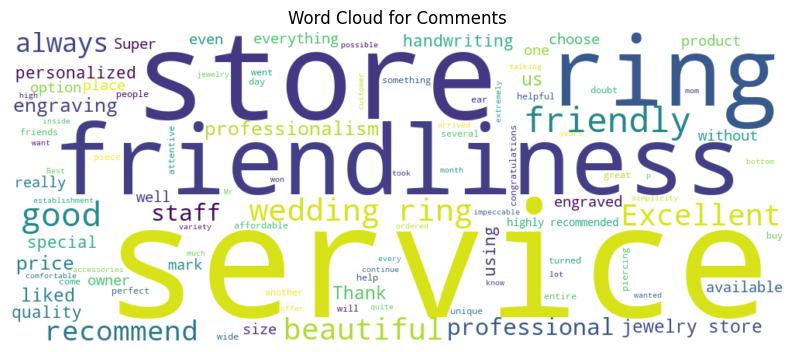

In [306]:
# Remove null values
feedback_data = feedback_data.dropna(subset=['Comment'])

# Filter out comments that are empty or just spaces
feedback_data = feedback_data[feedback_data['Comment'].str.strip() != ""]

# Generating the word cloud
wordcloud = WordCloud(background_color='white', width=1000, height=400, max_words=100).generate(" ".join(feedback_data['Comment']))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Comments')
plt.show()
